In [1]:
import pandas as pd
from dateutil import parser
from datetime import datetime # for converting and using dates
import pytz
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
articles = pd.read_csv("../../data/processed/gbh_geocoded_output.csv")
demographics = pd.read_csv("../../data/processed/demographics_by_tract.csv")

# Drop unnecessary columns
demographics = demographics.drop(columns=["Index", "Name", "State", "County"])

# Drop rows without neighborhoods
articles.dropna(subset=["Neighborhood"], inplace=True)

# Dictionary to map timezone names to pytz time zones
tzinfos = {'EST': pytz.timezone('US/Eastern'), 'EDT': pytz.timezone('US/Eastern')}

# Function to convert date strings to datetime objects
def convert_to_datetime(date_str):
    return parser.parse(date_str, tzinfos=tzinfos)

# Apply the conversion function to the 'Publication Date' column
articles['Publication Date'] = articles['Publication Date'].apply(convert_to_datetime)

# Ensure the Publication Date column is timezone-aware
articles['Publication Date'] = articles['Publication Date'].dt.tz_convert(pytz.timezone('US/Eastern'))

In [8]:
# Define the date range (example)
start_date = pytz.timezone('US/Eastern').localize(datetime(2020, 3, 1)) # This is the month with most published articles on the given data set
end_date = pytz.timezone('US/Eastern').localize(datetime(2025, 4, 1))

# Filter the DataFrame for the date range
filtered_articles = articles[(articles['Publication Date'] >= start_date) & (articles['Publication Date'] <= end_date)]

print(f"Using articles from {start_date.date()} to {end_date.date()}")

Using articles from 2020-03-01 to 2025-04-01


In [9]:
# Function to merge articles with demographics
def merge_articles_with_demographics(articles_df, demographics_df):
    merged_df = pd.merge(articles_df, demographics_df, on='Census Tract', how='left')
    return merged_df

merged_articles = merge_articles_with_demographics(filtered_articles, demographics)

In [10]:
# Identify predominant race for each census tract
merged_articles['Predominant Race'] = merged_articles[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].idxmax(axis=1)


C:\Users\axel0\AppData\Local\Temp\ipykernel_7660\621068851.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  merged_articles['Predominant Race'] = merged_articles[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].idxmax(axis=1)


In [14]:
import numpy as np

# Group data by Census Tract and calculate the race distribution
race_distribution_by_tract = merged_articles.groupby('Census Tract')[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].sum()

# Normalize to get percentages
race_distribution_by_tract_percentage = race_distribution_by_tract.div(race_distribution_by_tract.sum(axis=1), axis=0) * 100

# Reset index for easier plotting
race_distribution_by_tract_percentage = race_distribution_by_tract_percentage.reset_index()


In [21]:
# Function to check thresholds
def check_thresholds(race_distribution, thresholds):
    results = {}
    for threshold in thresholds:
        counts = (race_distribution >= threshold).sum()
        results[threshold] = counts
    return pd.DataFrame(results)

# Define thresholds
thresholds = [30, 40, 50, 60, 70, 80, 90]

# Check how many census tracts surpass each threshold
threshold_results = check_thresholds(race_distribution_by_tract_percentage, thresholds)
print("Number of Census Tracts surpassing each threshold by race:")
print(threshold_results)

Number of Census Tracts surpassing each threshold by race:
                                           30   40   50   60   70   80   90
Census Tract                              104  104  104  104  104  104  104
White                                      86   78   70   61   44   32    7
African American                           25   24   20   16   10    9    4
American Indian and Alaska Native           0    0    0    0    0    0    0
Asian                                      15    6    2    1    0    0    0
Native Hawaiian and Other Pacific Island    0    0    0    0    0    0    0
Other                                       0    0    0    0    0    0    0


Predominant Race
White                              62
African American                   17
White & Asian                      15
White & African American            8
White, African American & Asian     1
Mixed/Other                         1
Name: count, dtype: int64


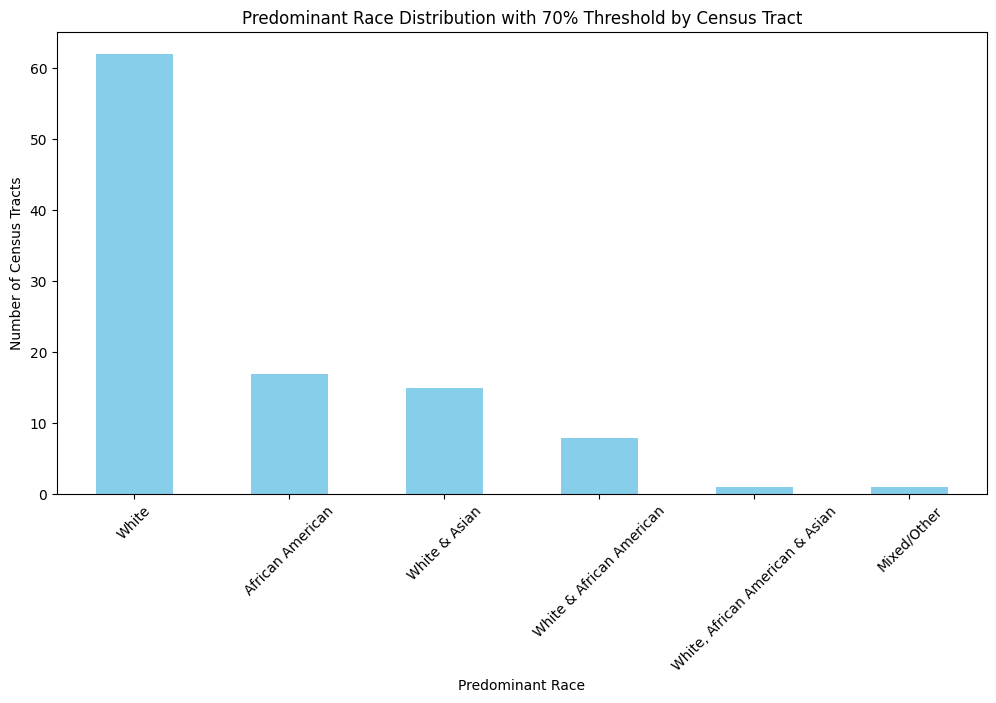

In [36]:
import pandas as pd

# Group data by Census Tract and calculate the race distribution
race_distribution_by_tract = merged_articles.groupby('Census Tract')[['White', 'African American', 'Asian']].sum()

# Normalize to get percentages
race_distribution_by_tract_percentage = race_distribution_by_tract.div(race_distribution_by_tract.sum(axis=1), axis=0) * 100

# Function to determine predominant race based on 70% threshold and combinations
def determine_predominant_race(row):
    # Check if any race meets the 70% threshold
    predominant_race = row[row >= 70].idxmax() if (row >= 70).any() else None

    if predominant_race:
        return predominant_race
    else:
        # Check for combinations
        top_races = row[row >= 30].index.tolist()  # Consider races with at least 20%
        if len(top_races) == 1:
            return top_races[0]
        if len(top_races) == 2:
            return f"{top_races[0]} & {top_races[1]}"
        elif len(top_races) == 3:
            return f"{top_races[0]}, {top_races[1]} & {top_races[2]}"
        else:
            return "Mixed/Other"

# Apply the function to each row to determine the predominant race or combination
race_distribution_by_tract_percentage['Predominant Race'] = race_distribution_by_tract_percentage.apply(determine_predominant_race, axis=1)

# Merge the new predominant race information back into the merged_articles DataFrame
predominant_race_mapping = race_distribution_by_tract_percentage['Predominant Race'].to_dict()

# Update the Predominant Race column in merged_articles
merged_articles['Predominant Race'] = merged_articles['Census Tract'].map(predominant_race_mapping)

# Display the results
print(race_distribution_by_tract_percentage['Predominant Race'].value_counts())

# Visualize the results
import matplotlib.pyplot as plt

# Count the occurrences of each predominant race category
predominant_race_counts = race_distribution_by_tract_percentage['Predominant Race'].value_counts()

# Plot the results as a bar chart
plt.figure(figsize=(12, 6))
predominant_race_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Predominant Race')
plt.ylabel('Number of Census Tracts')
plt.title('Predominant Race Distribution with 70% Threshold by Census Tract')
plt.xticks(rotation=45)
plt.show()

C:\Users\axel0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


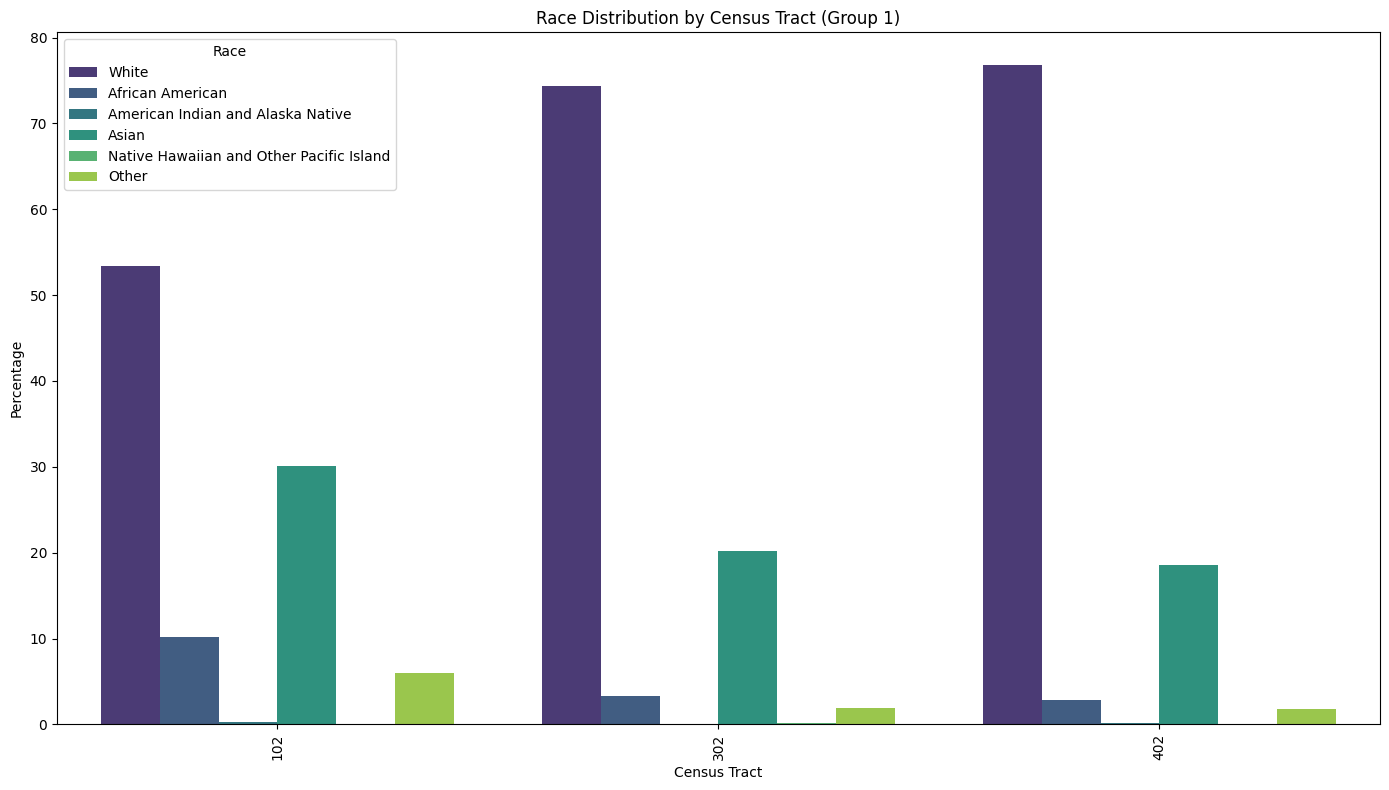

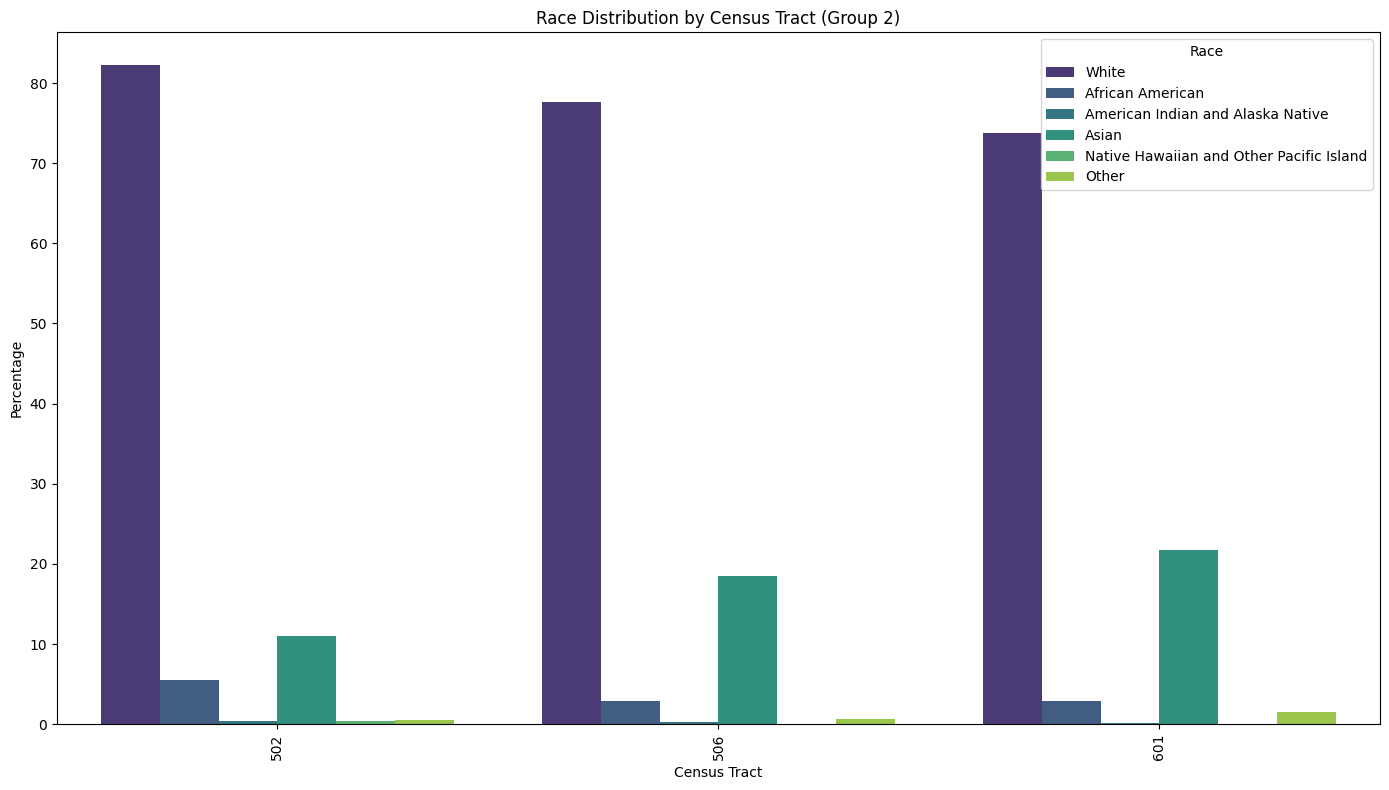

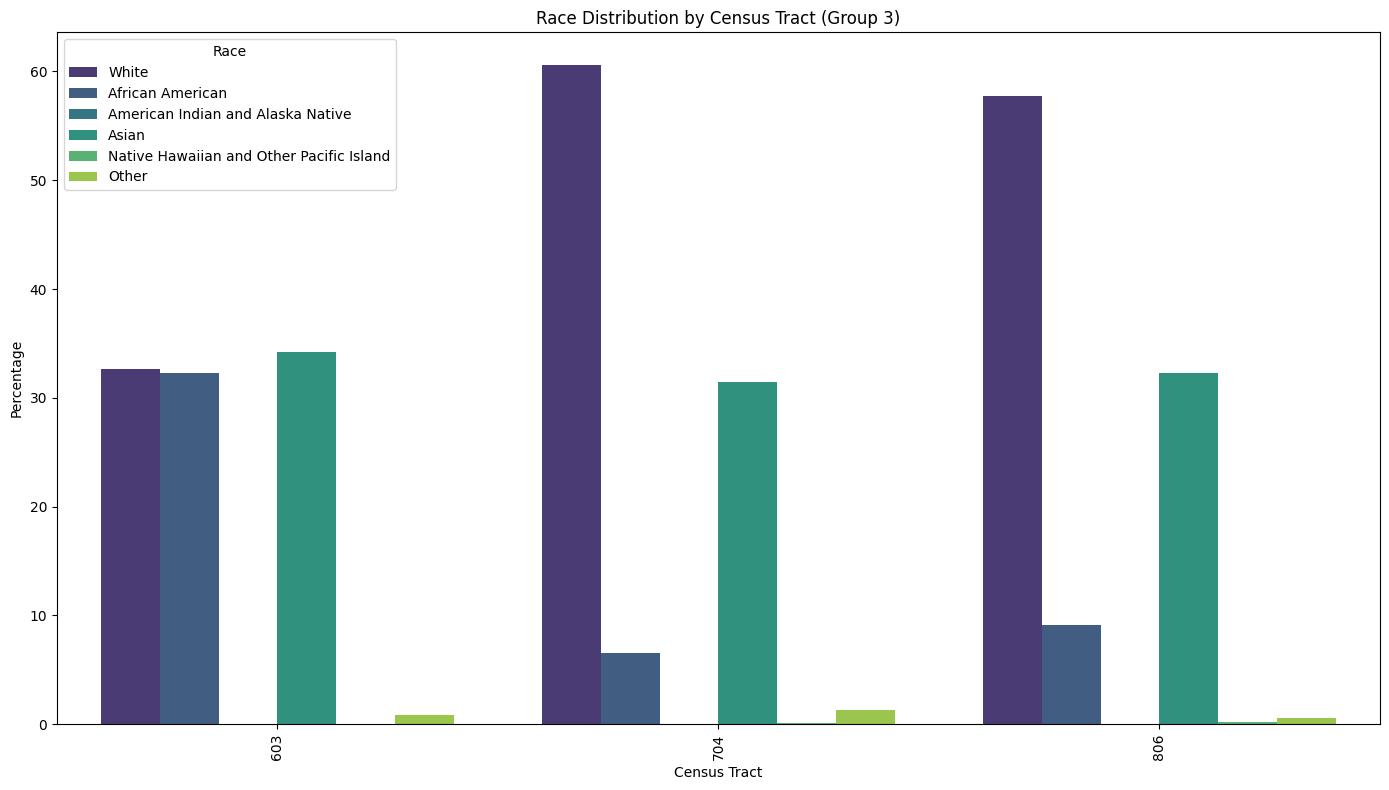

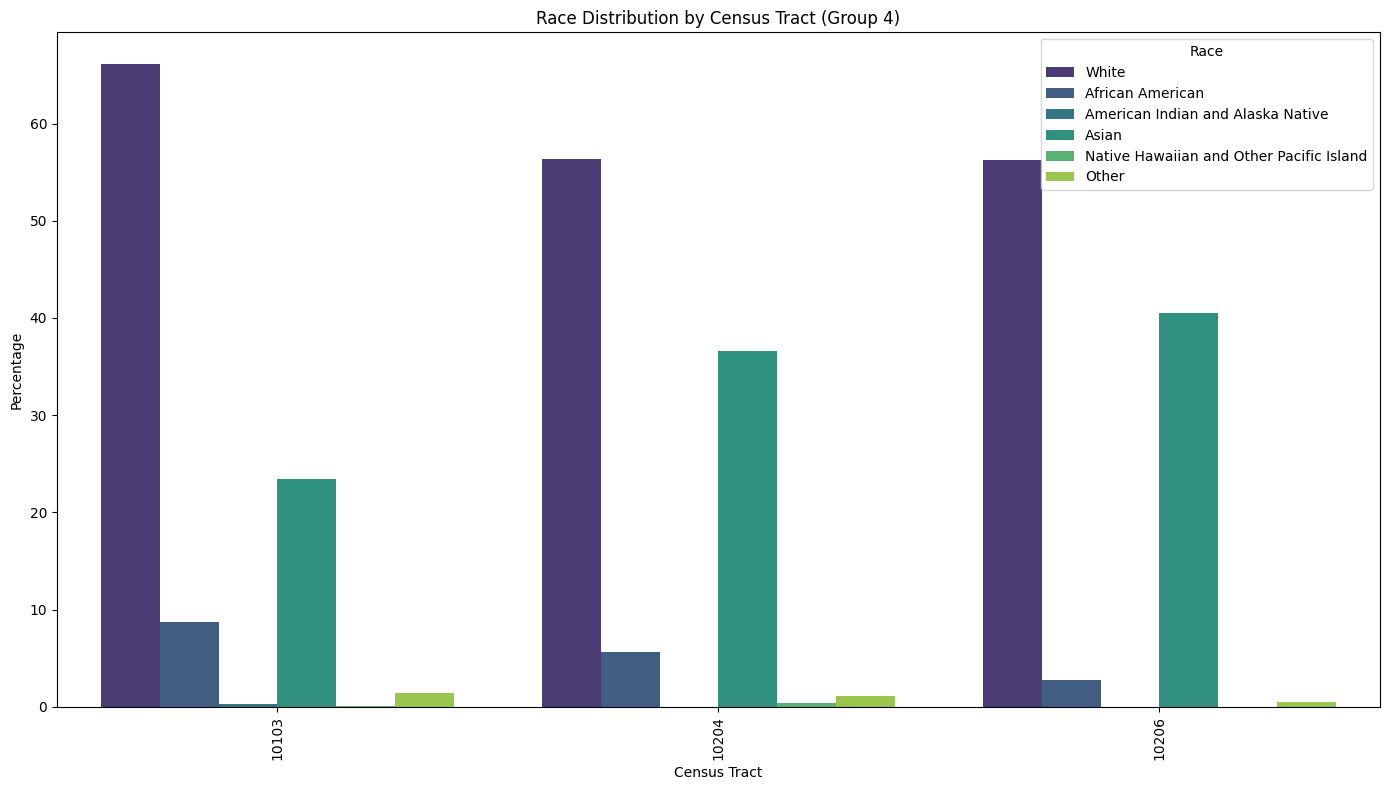

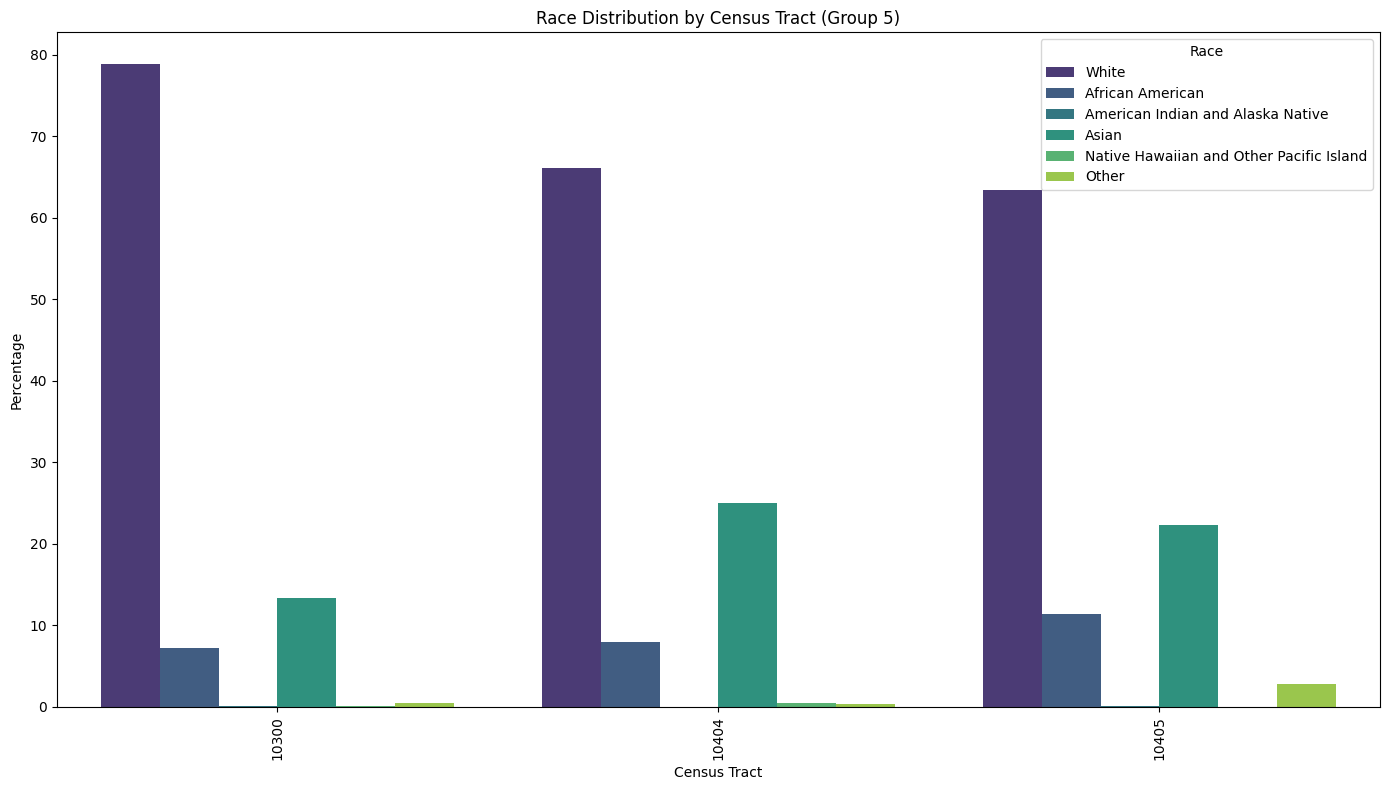

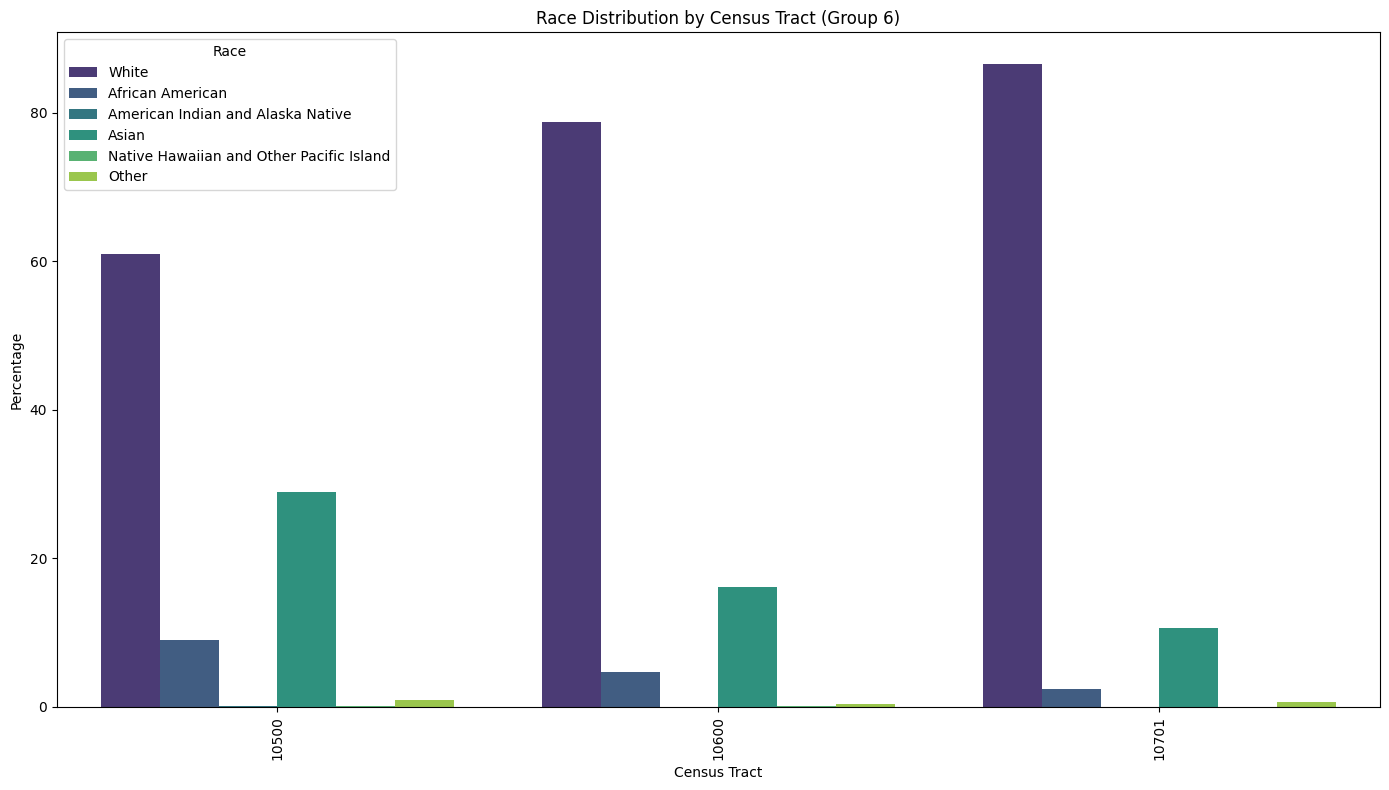

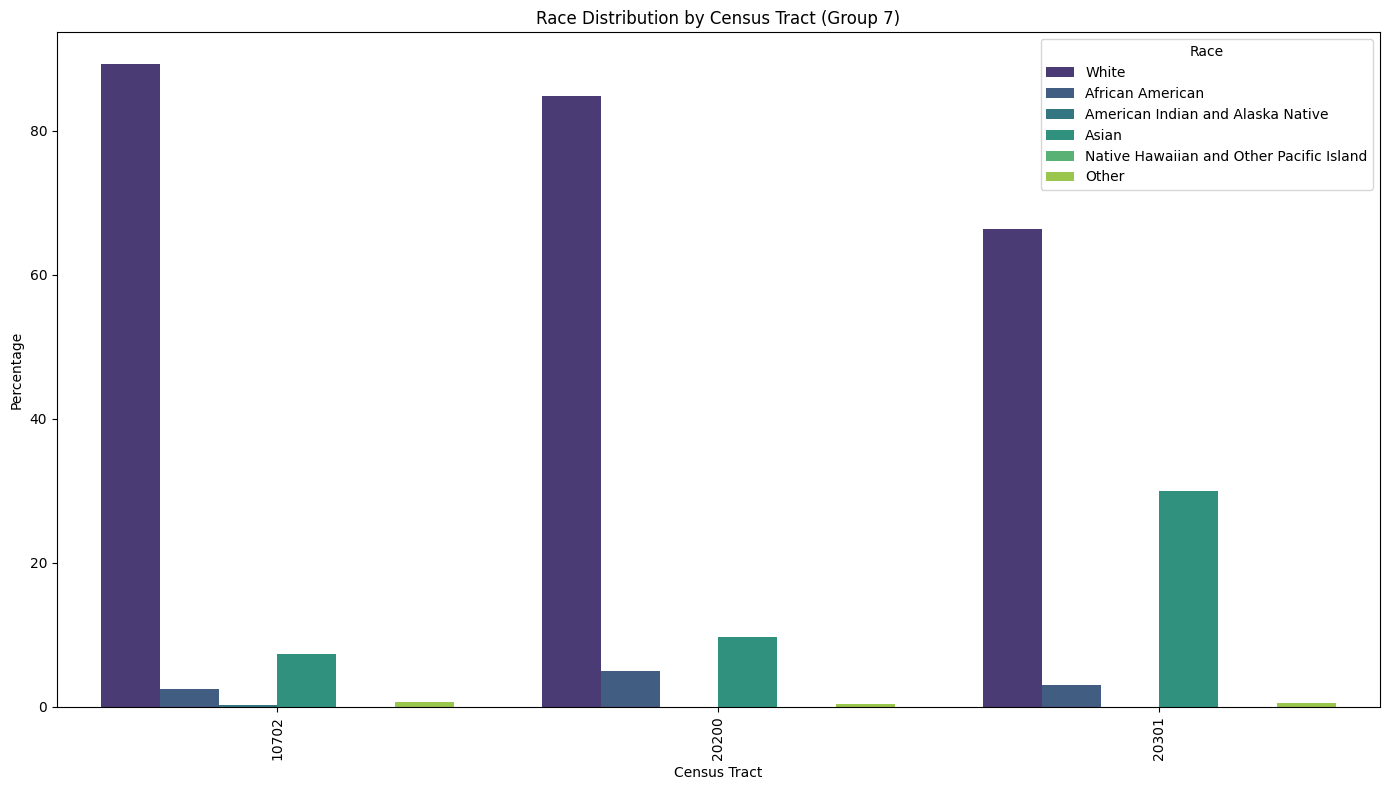

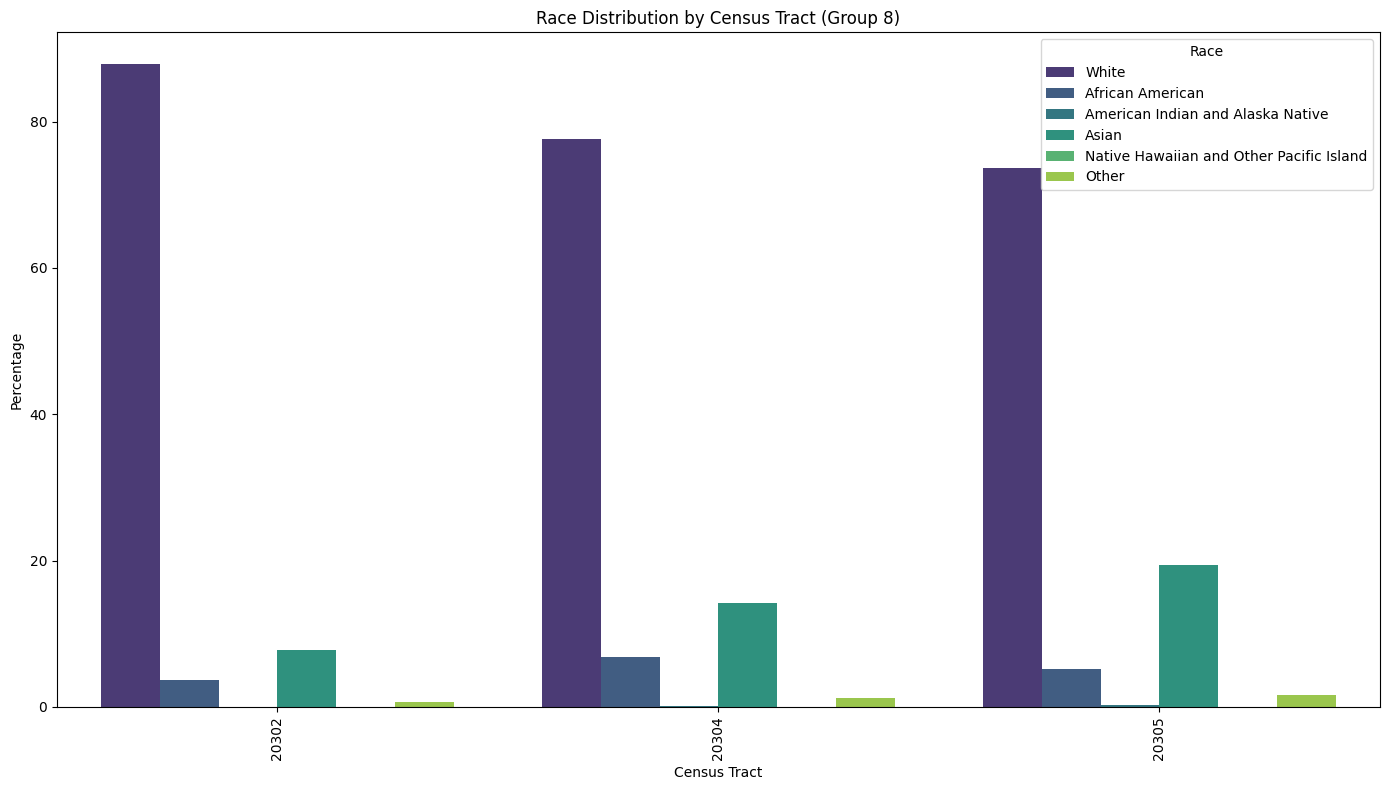

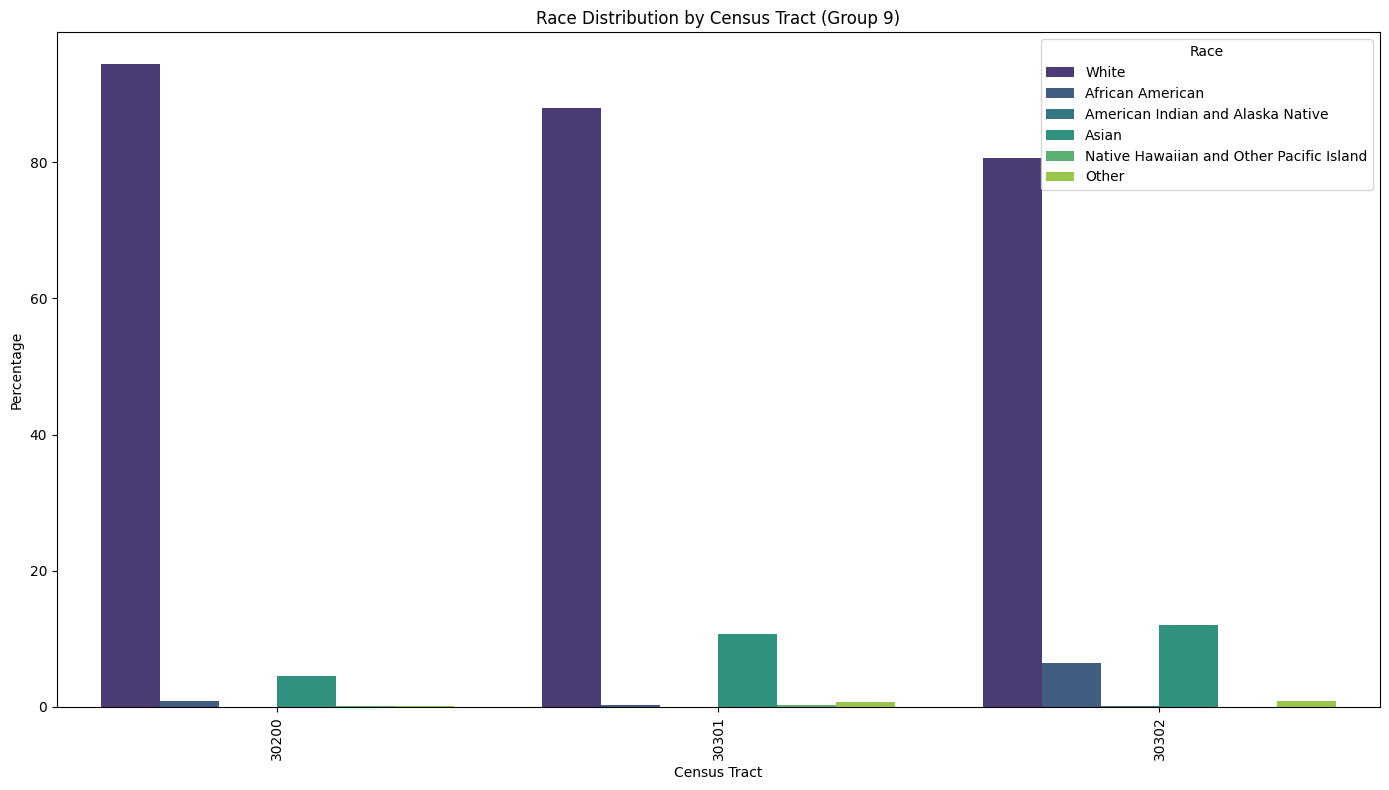

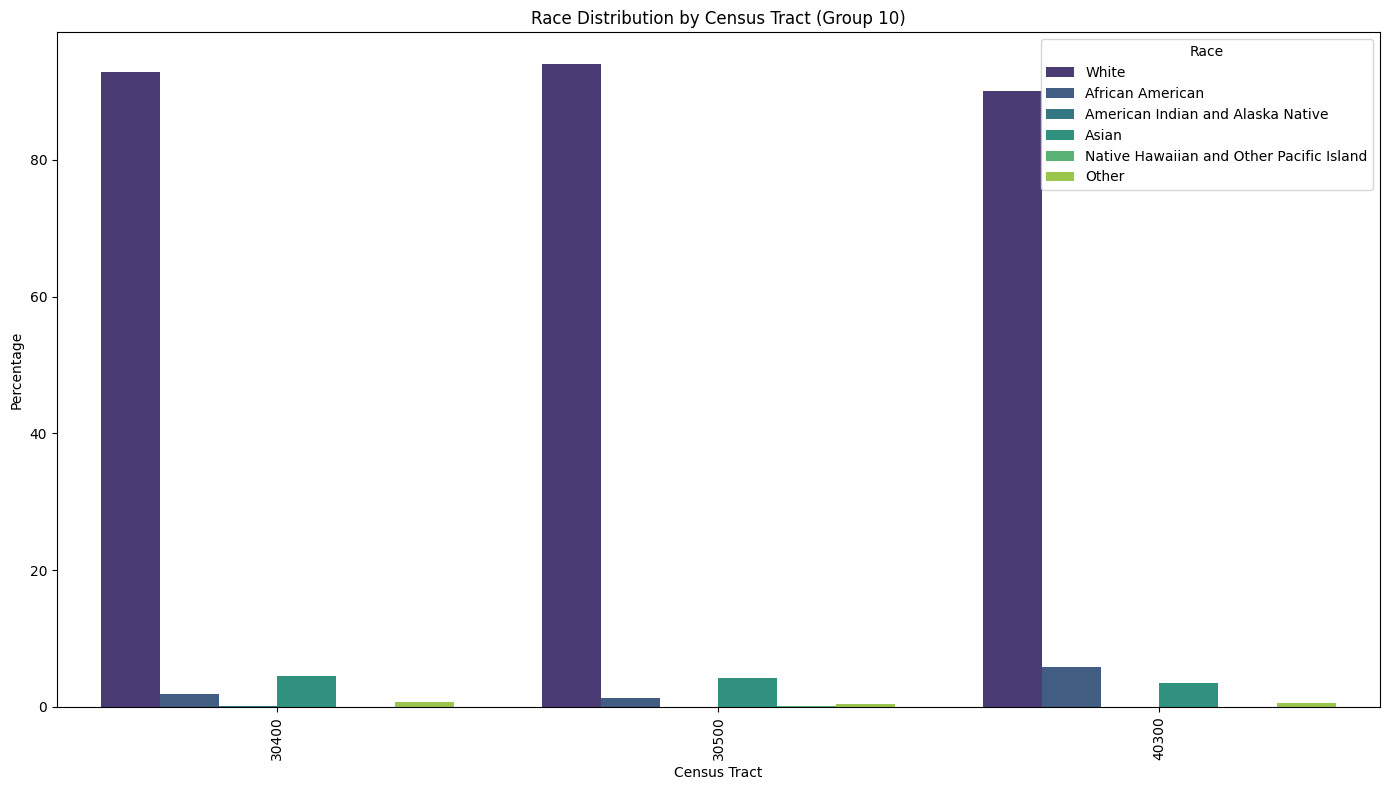

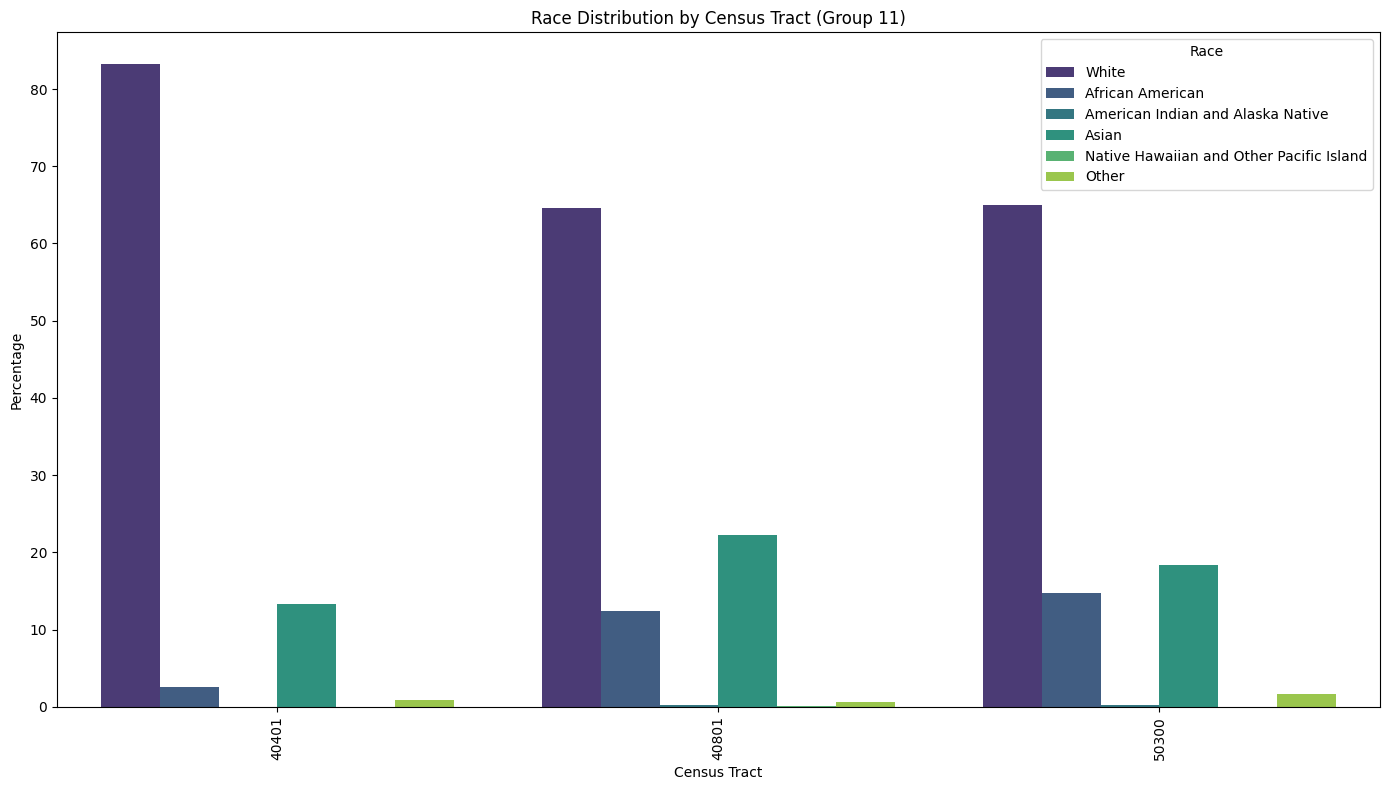

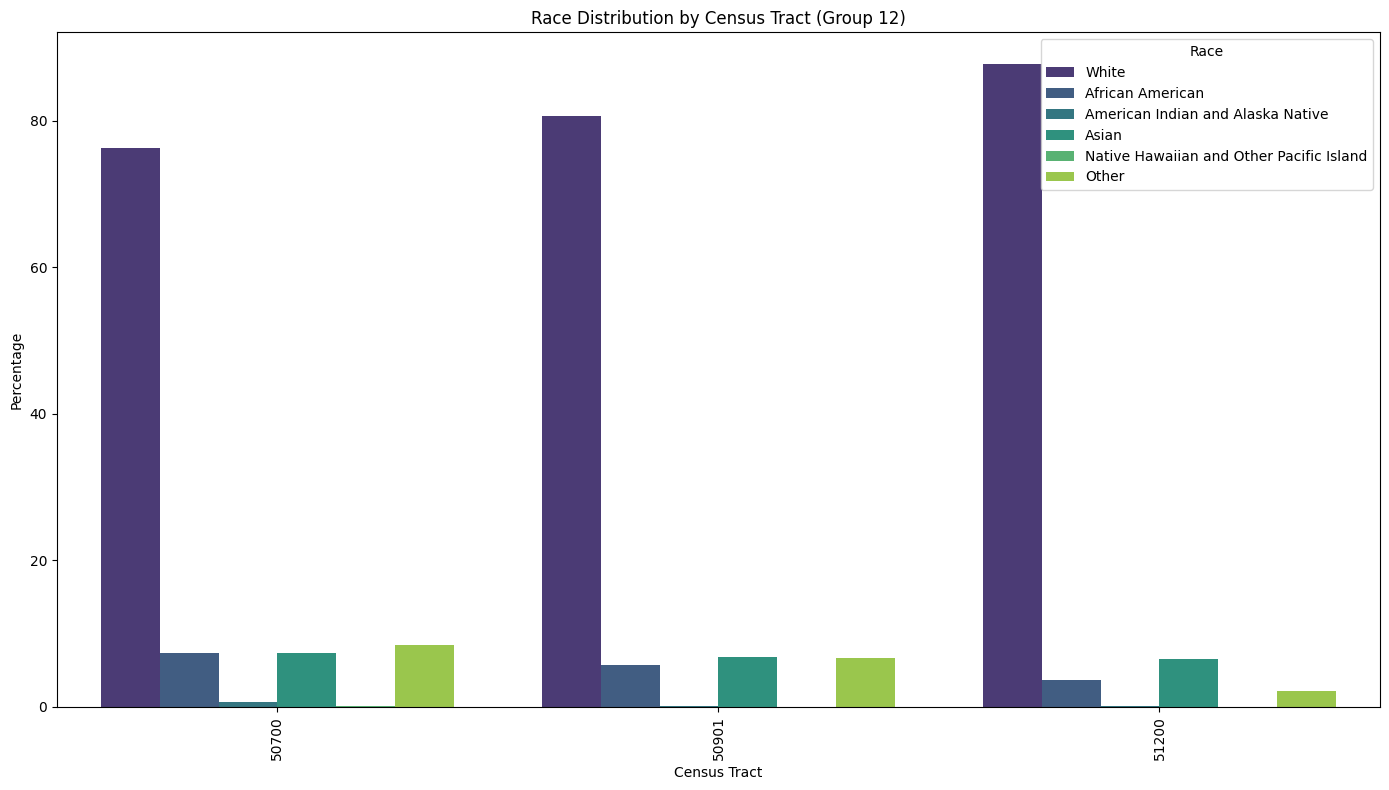

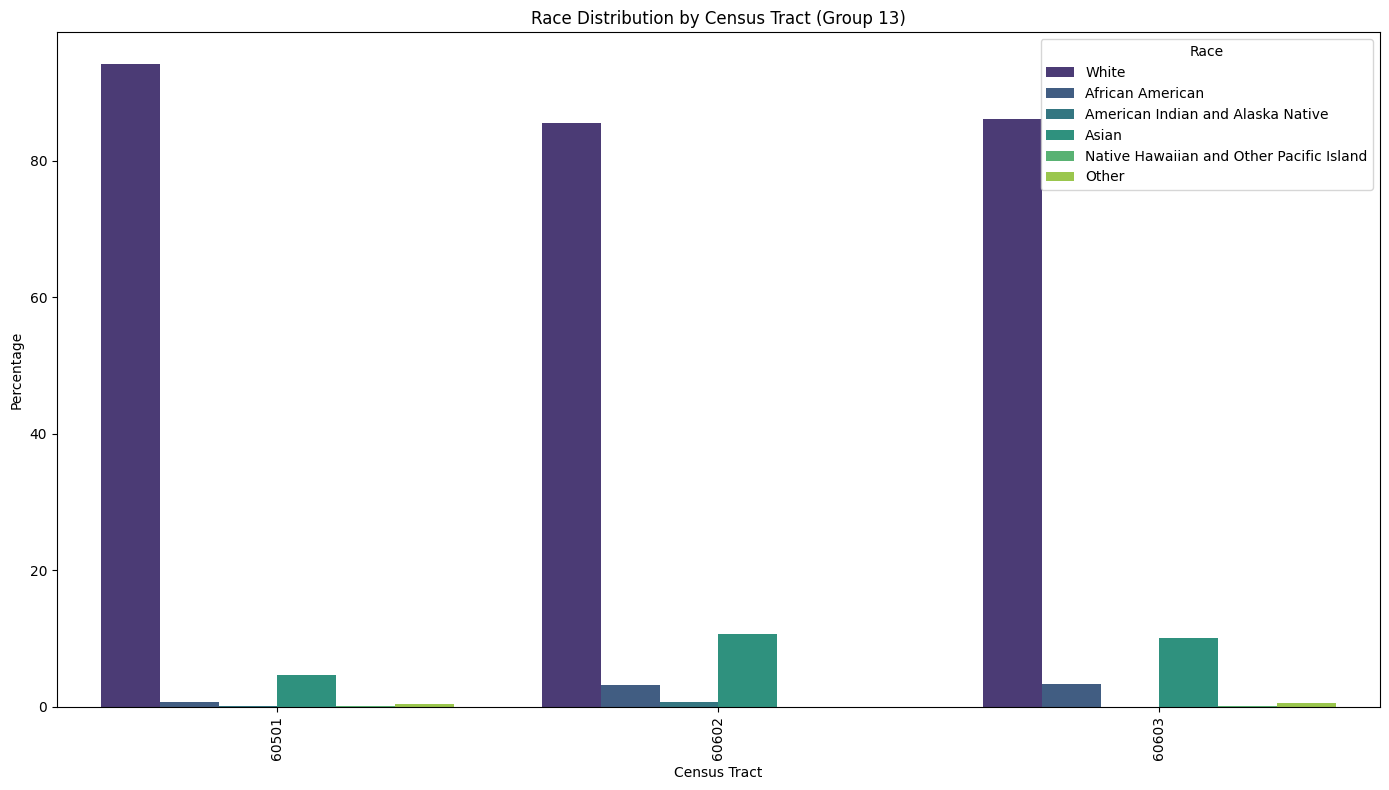

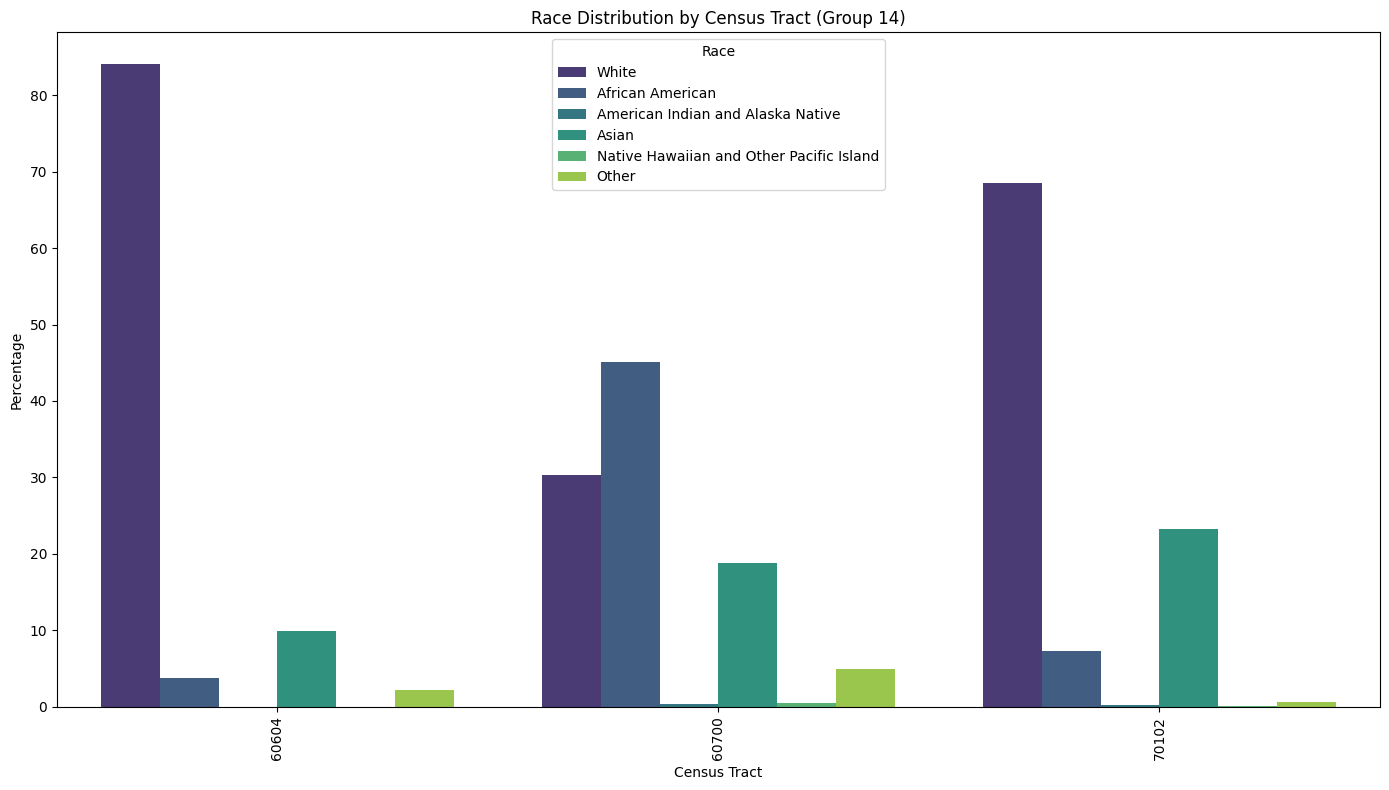

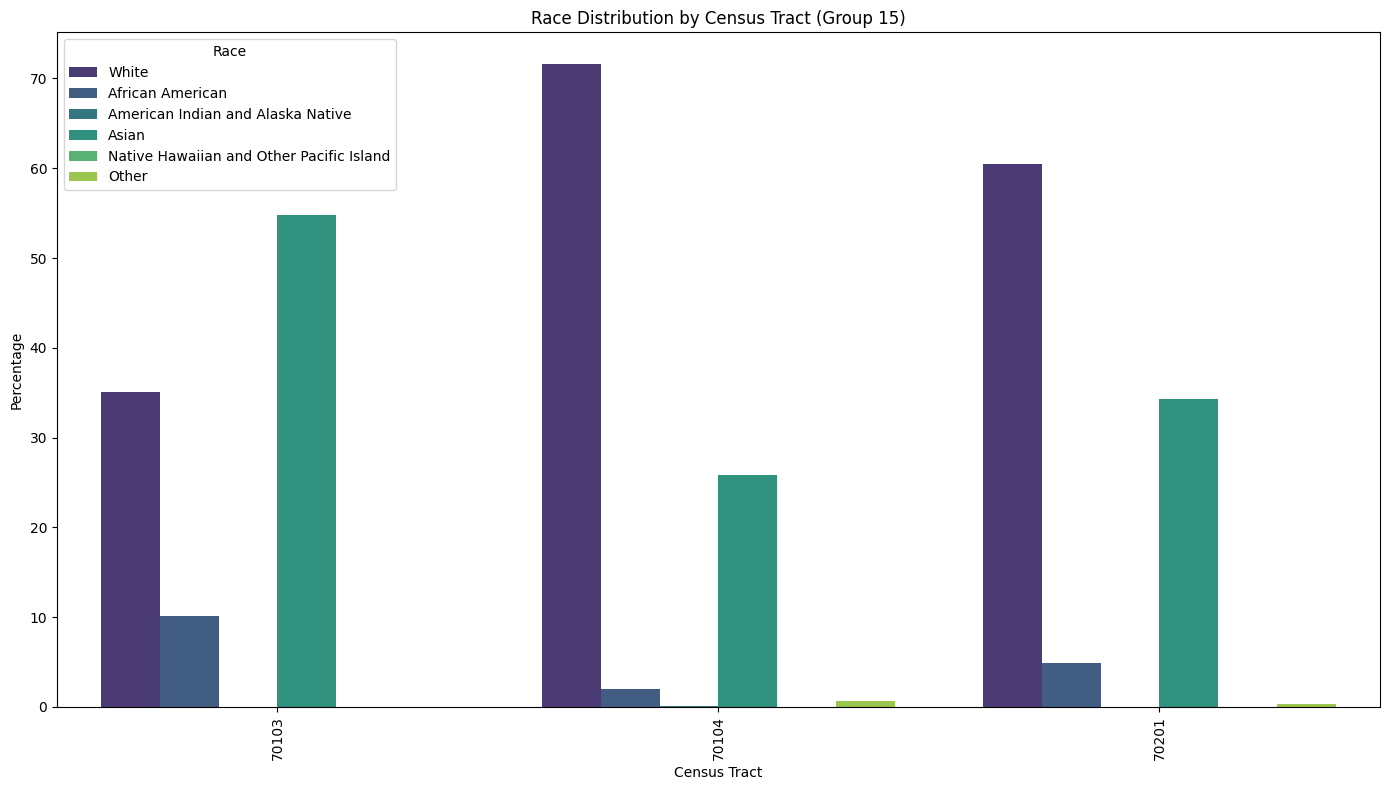

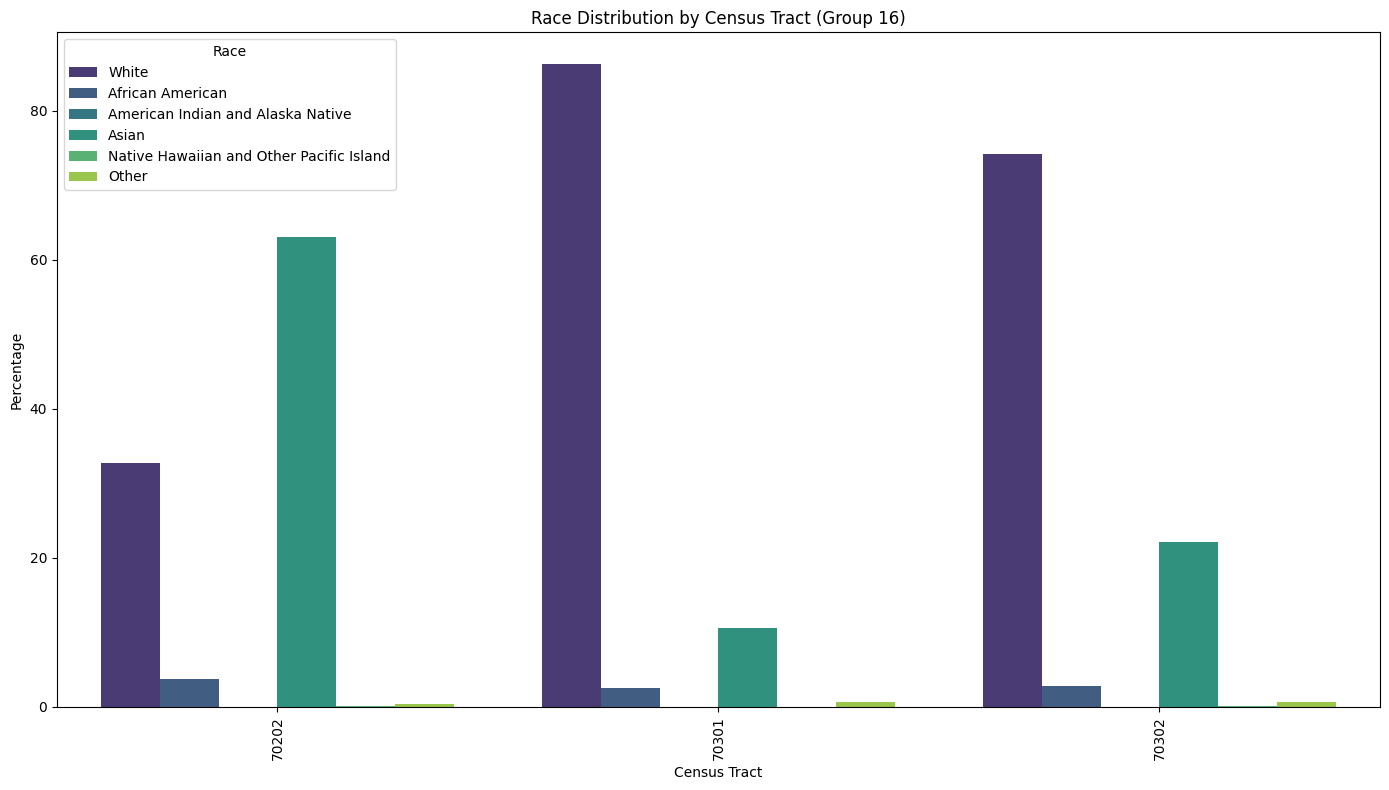

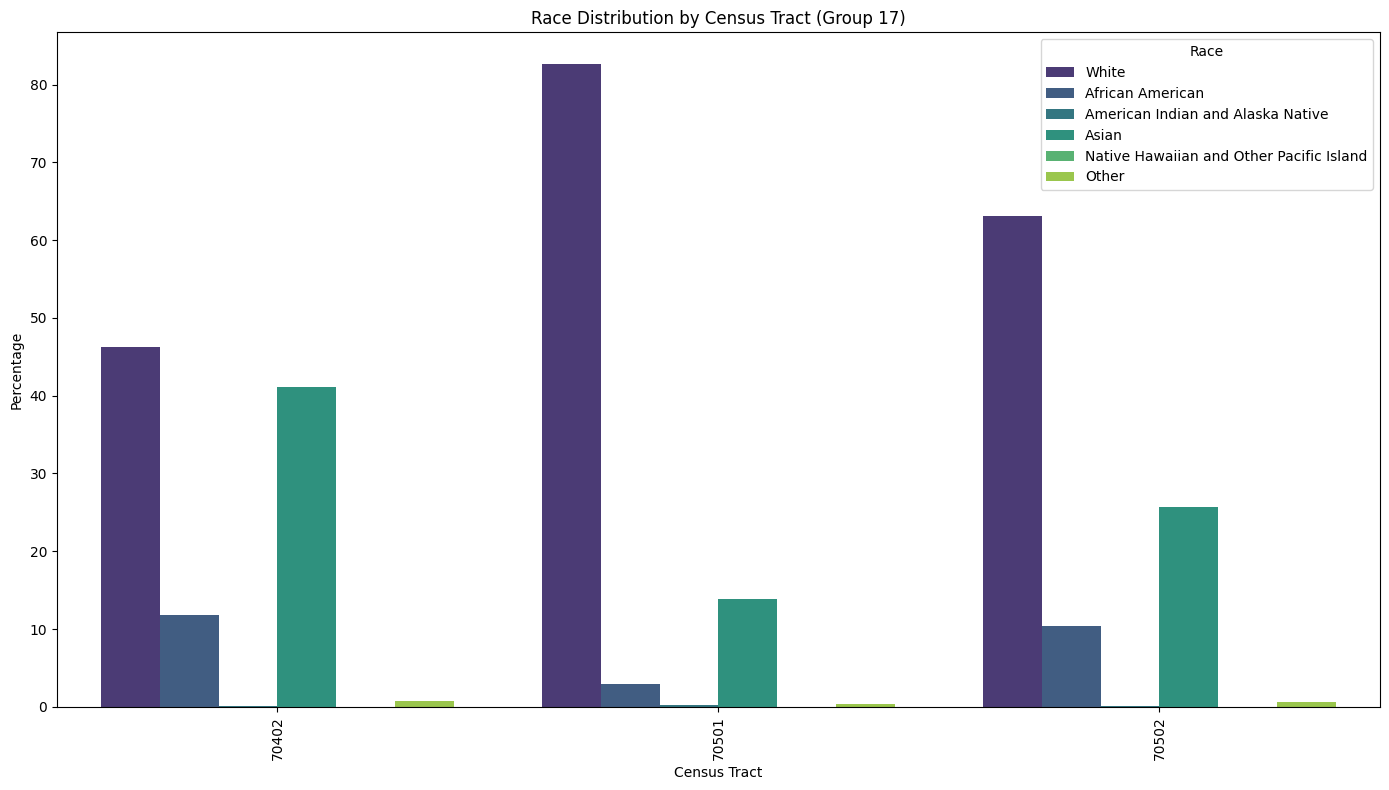

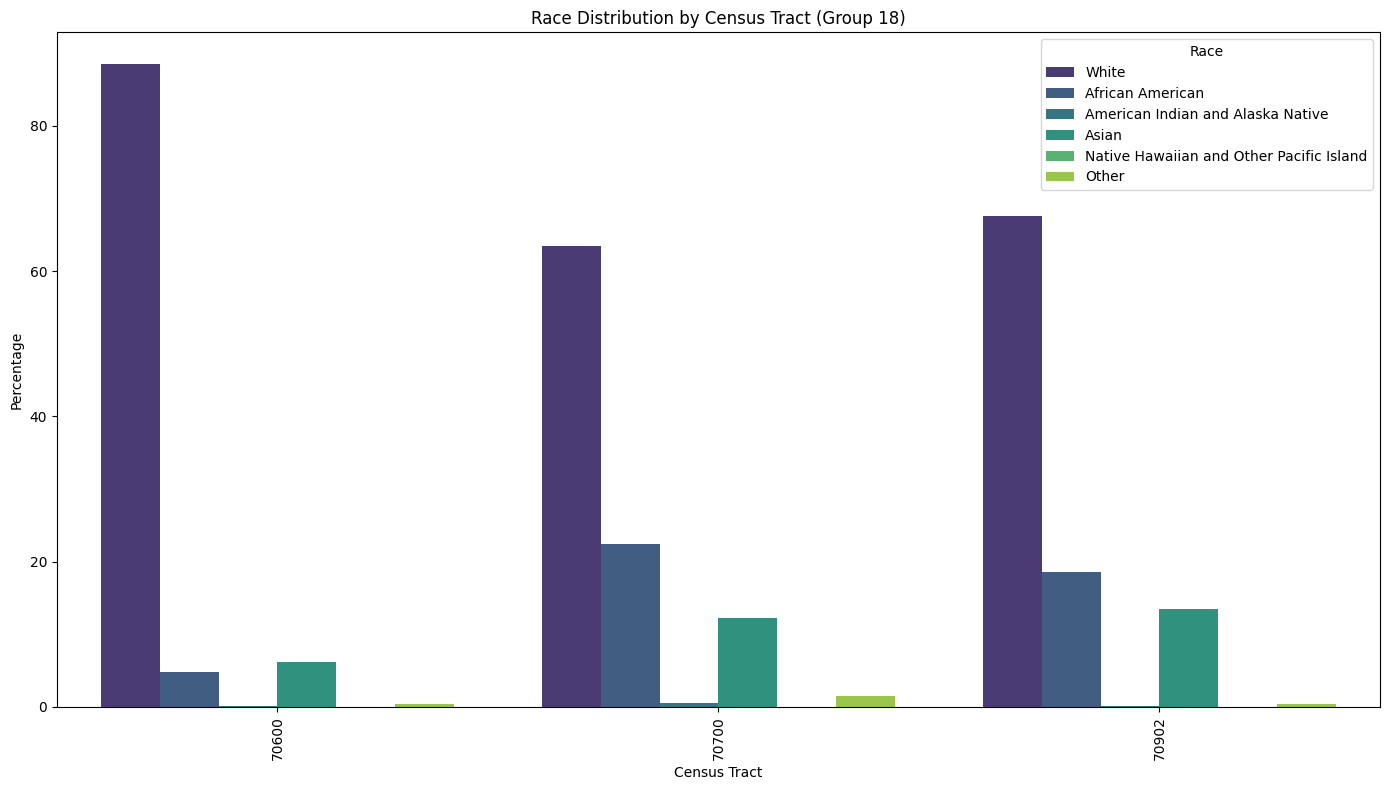

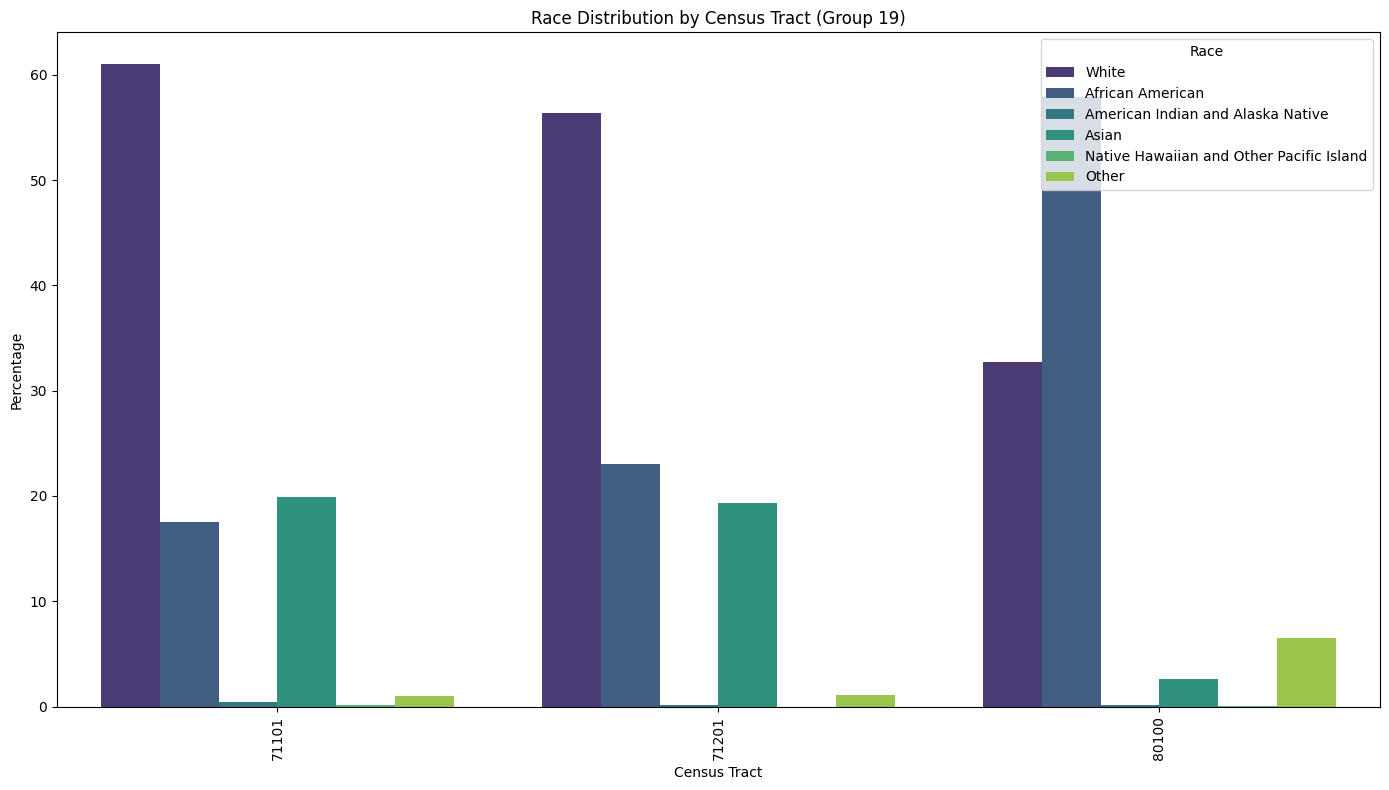

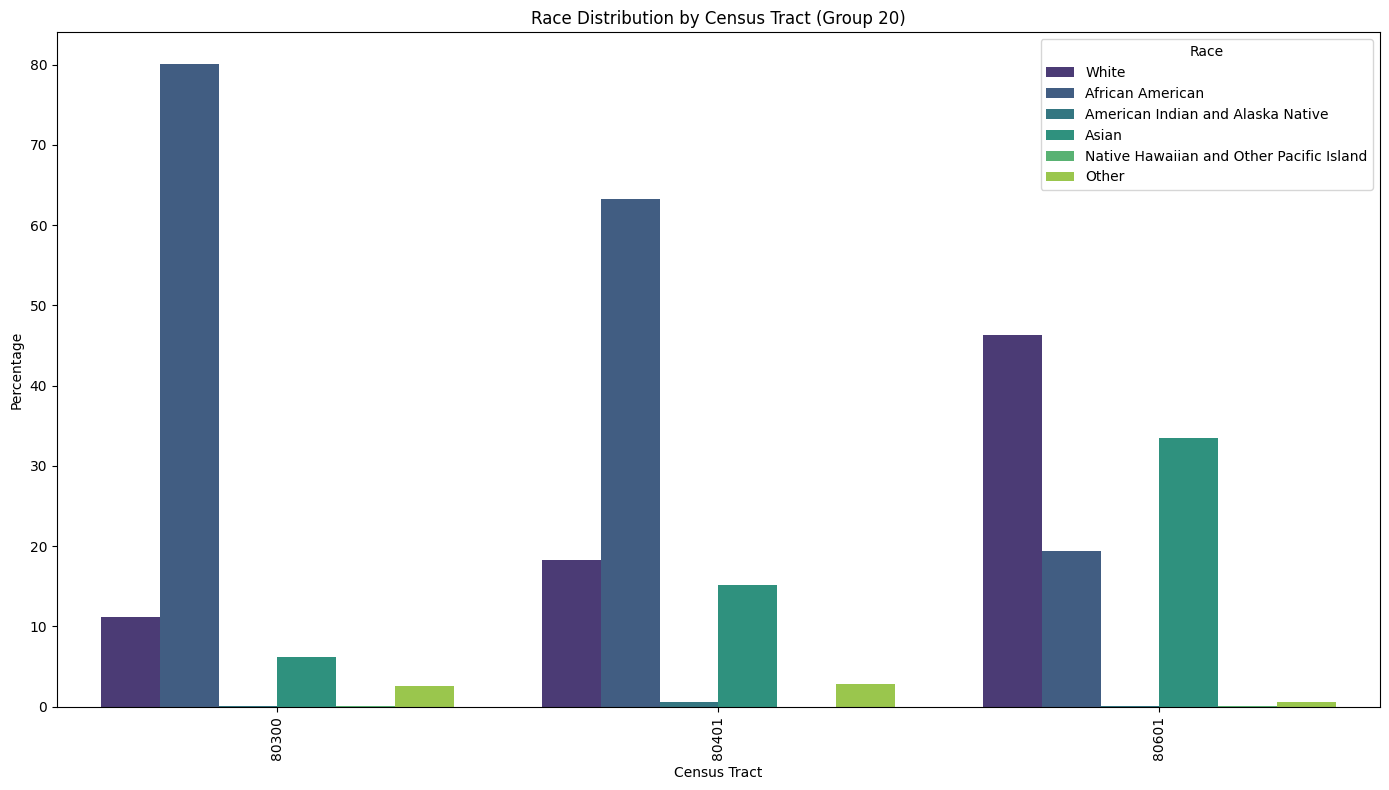

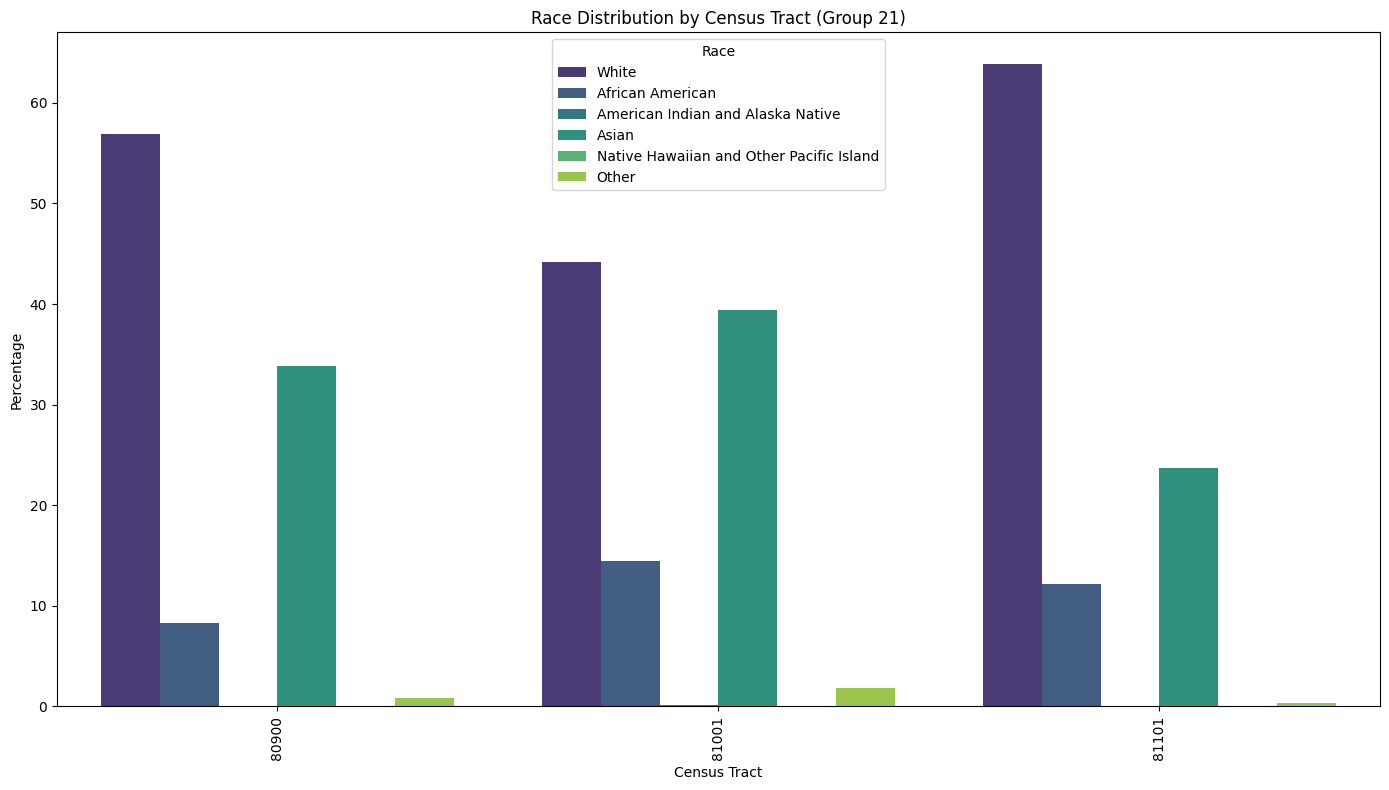

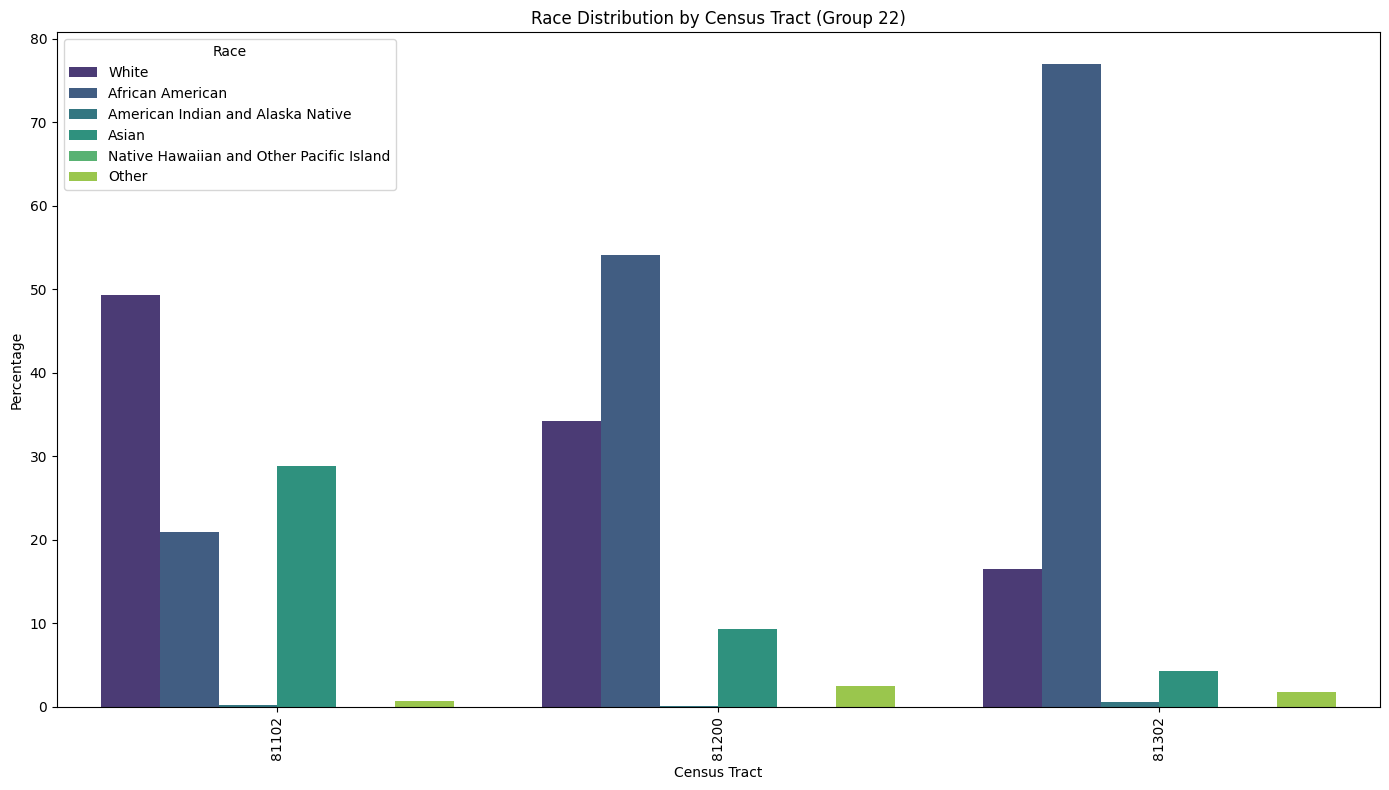

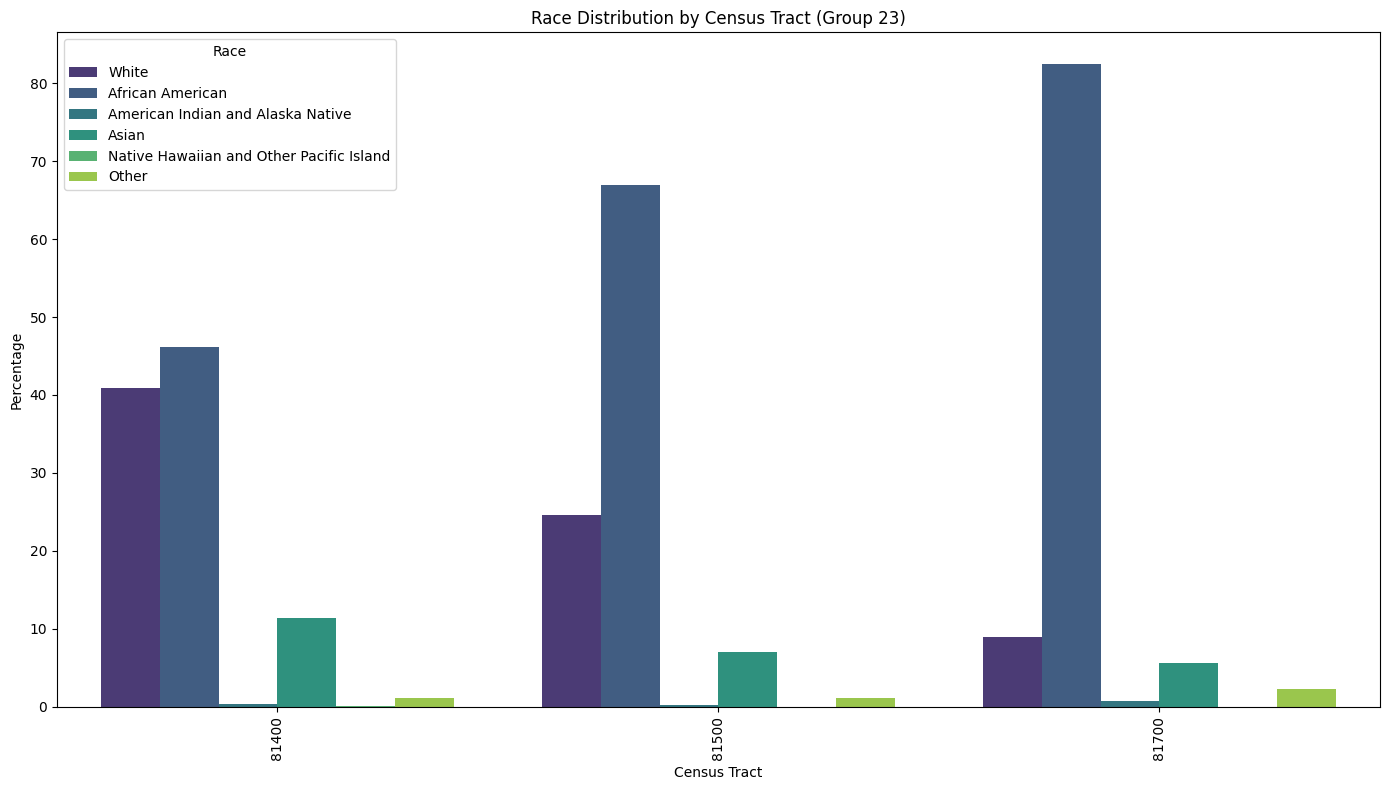

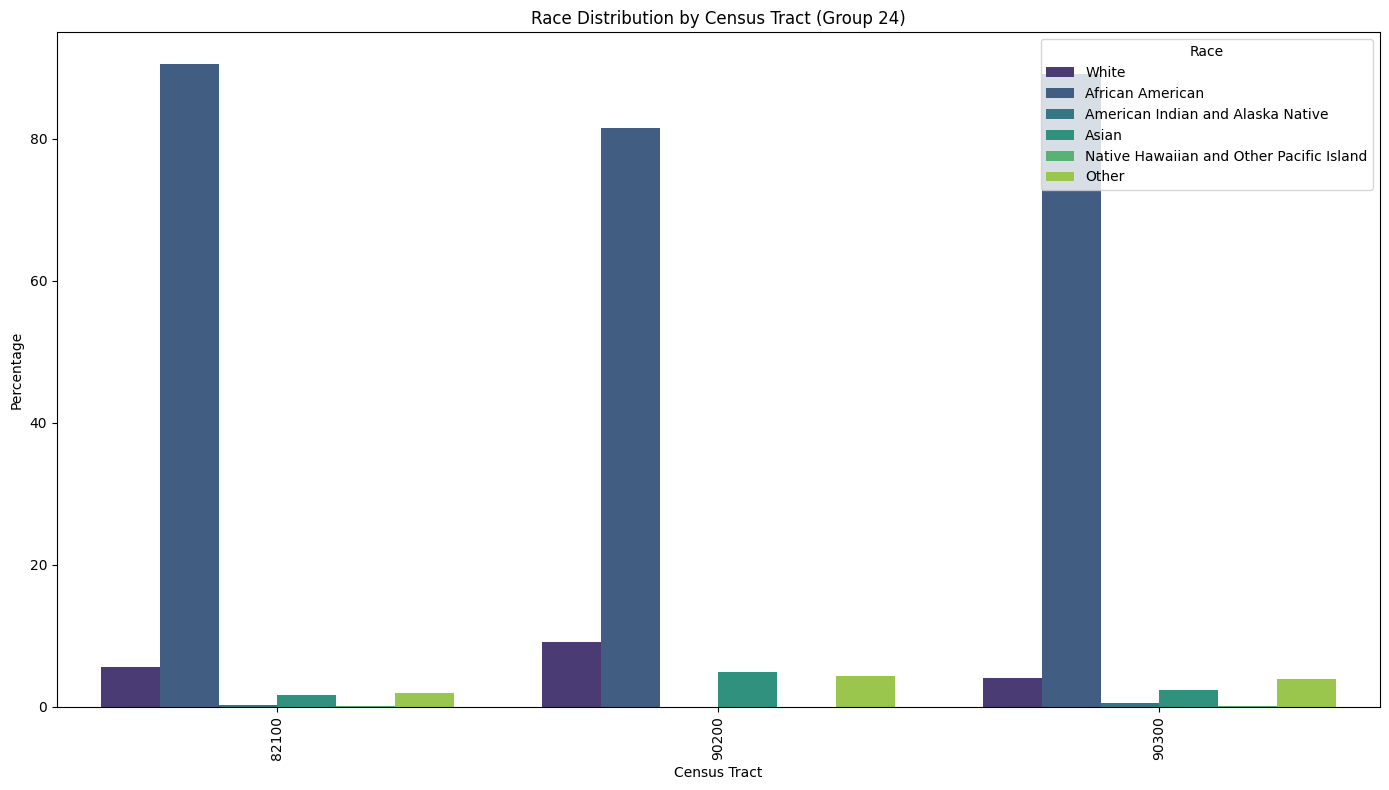

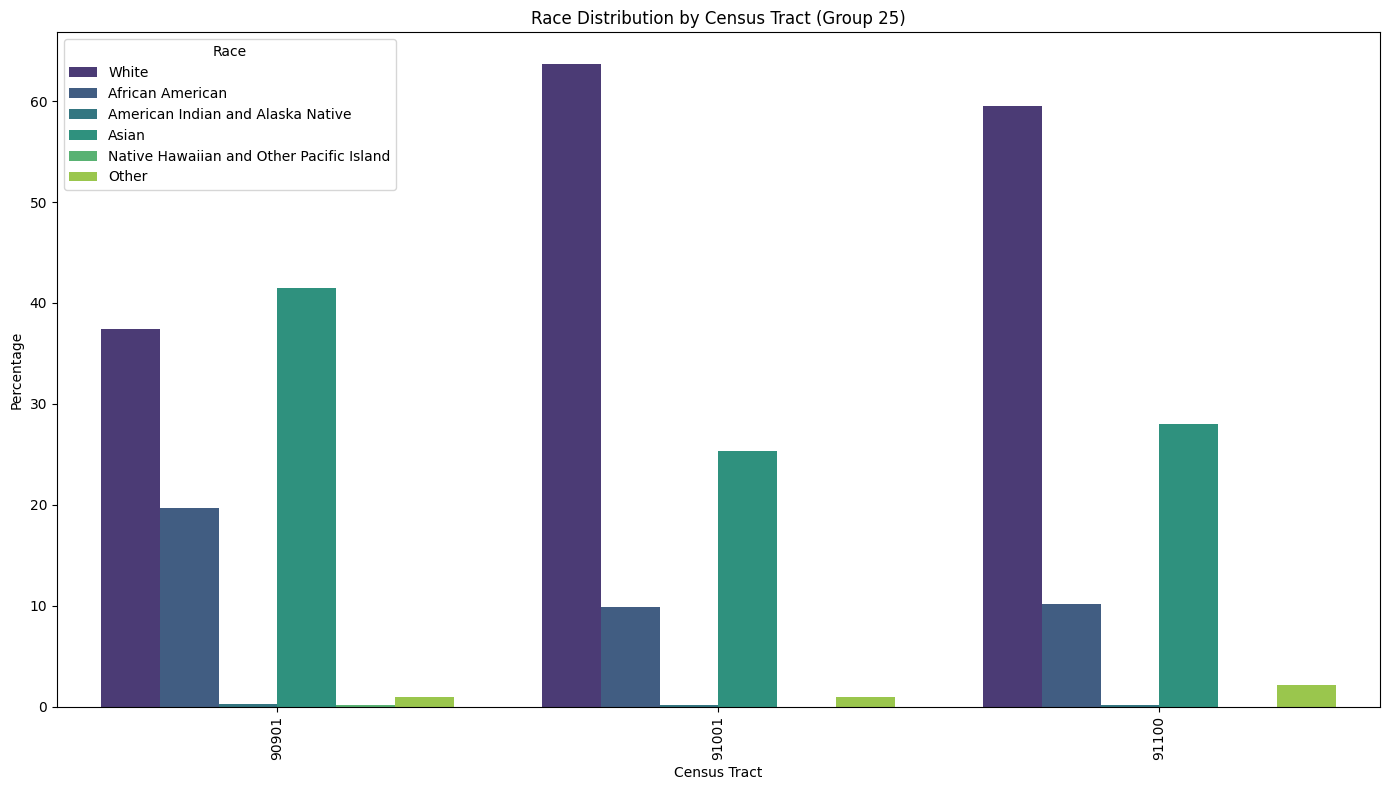

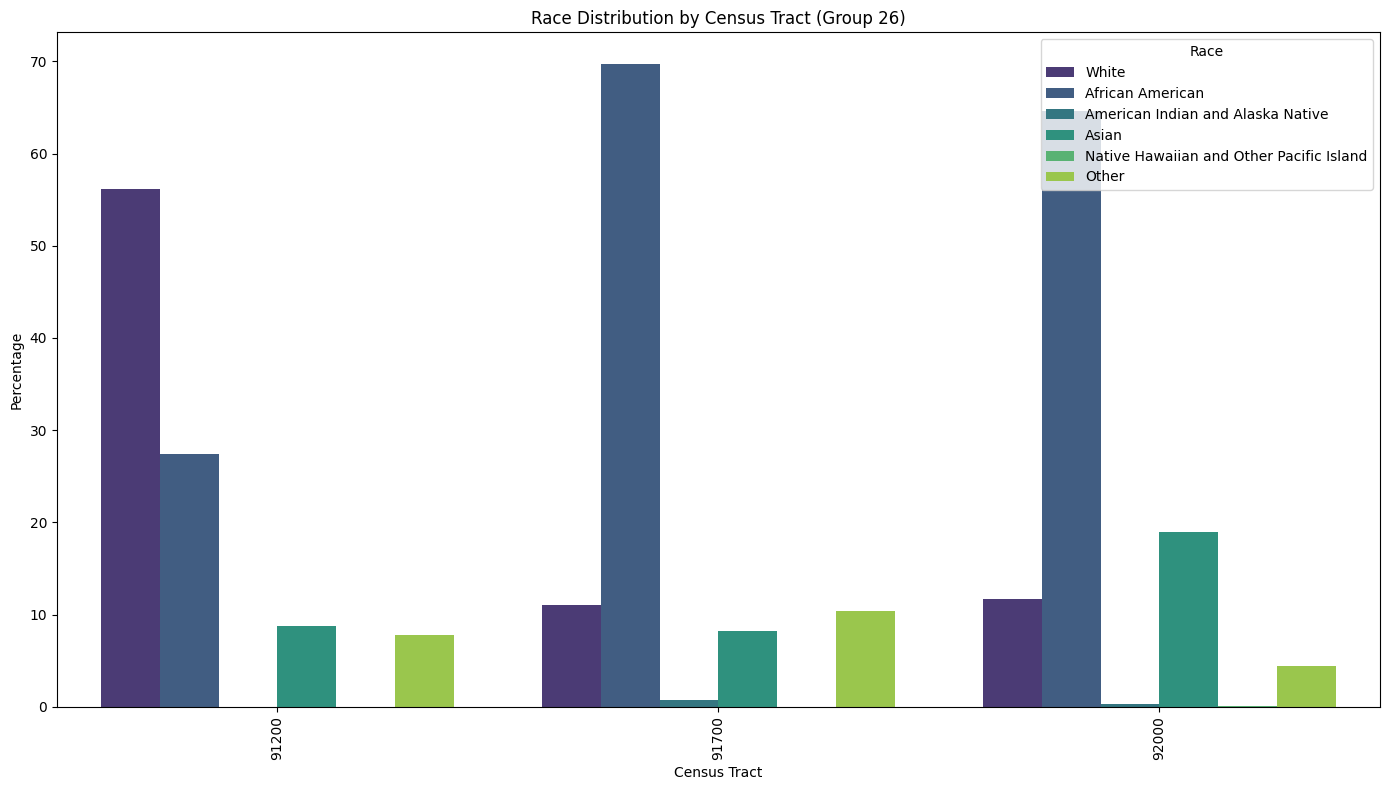

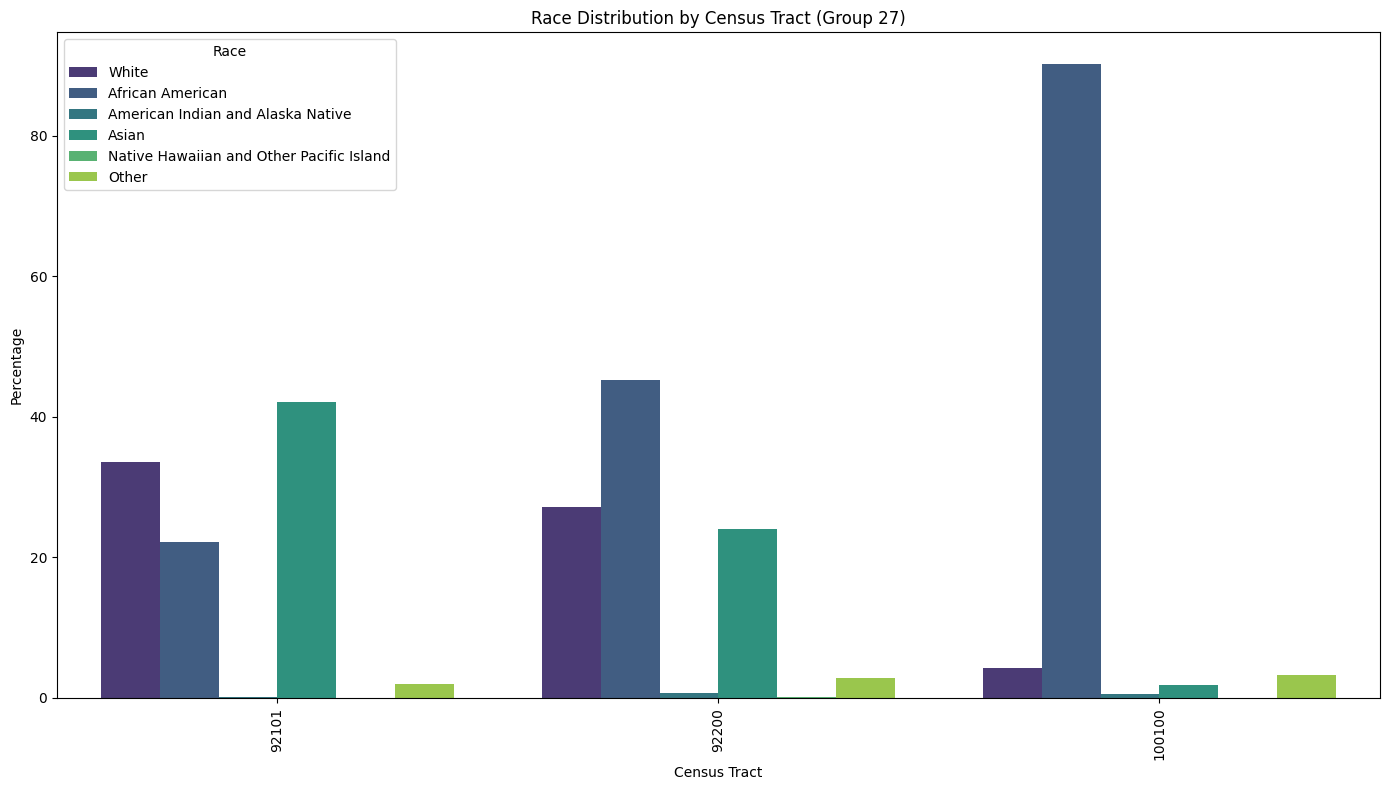

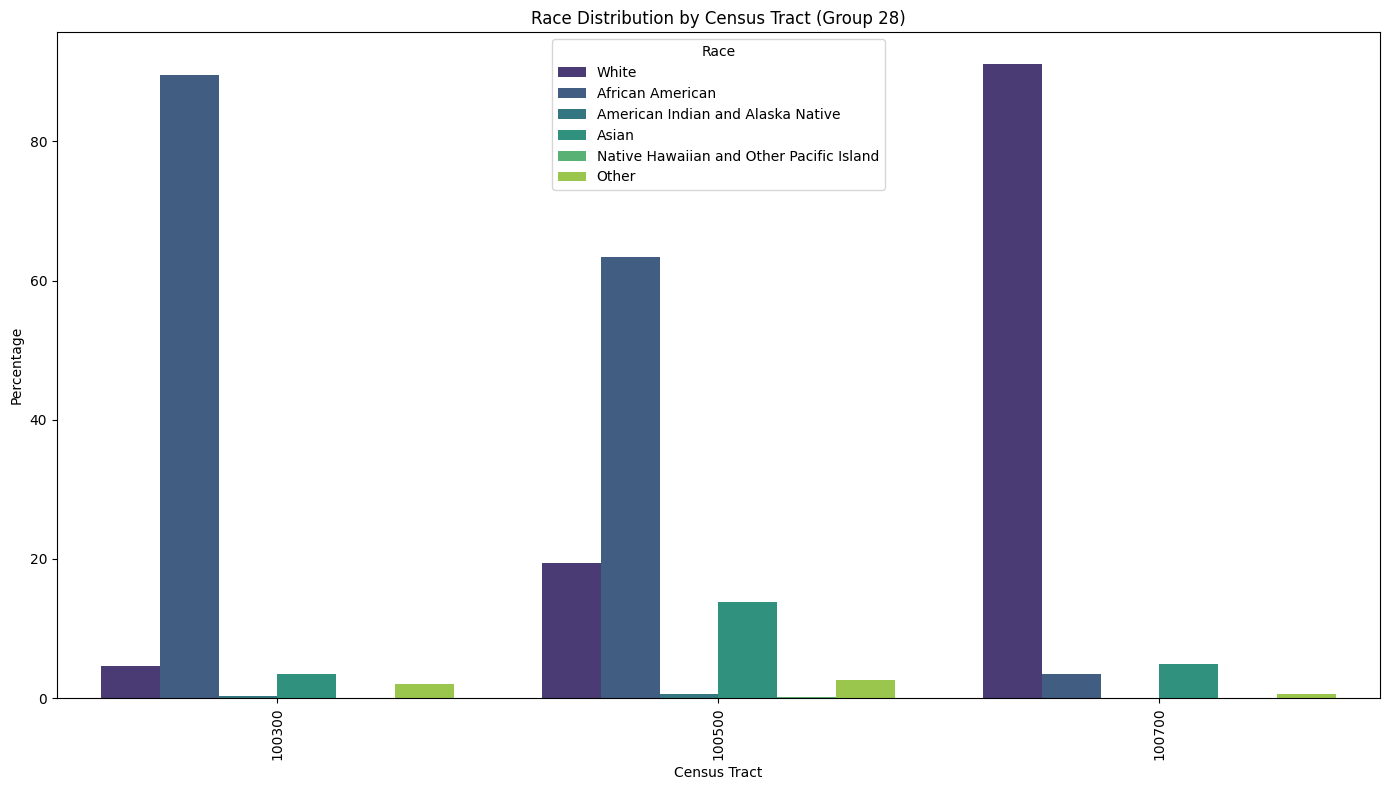

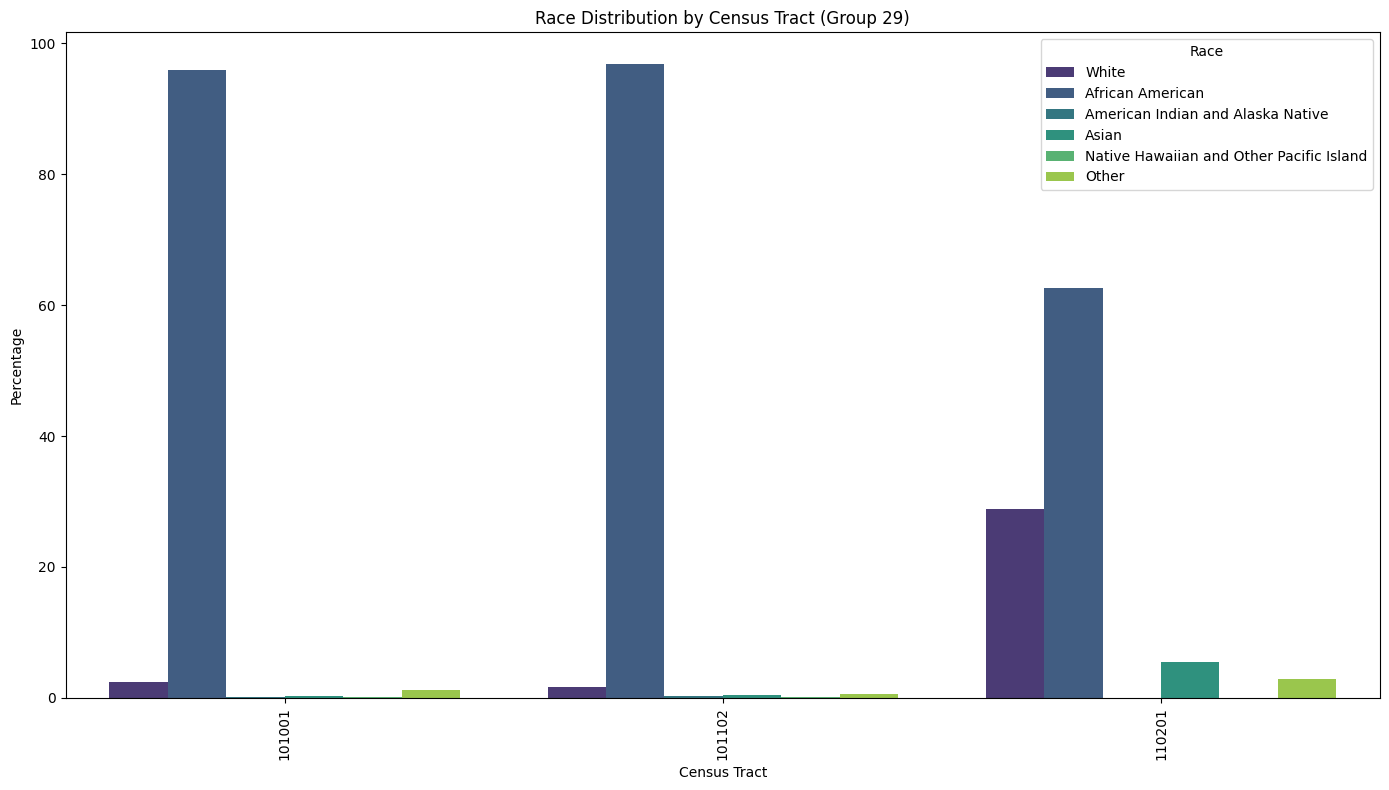

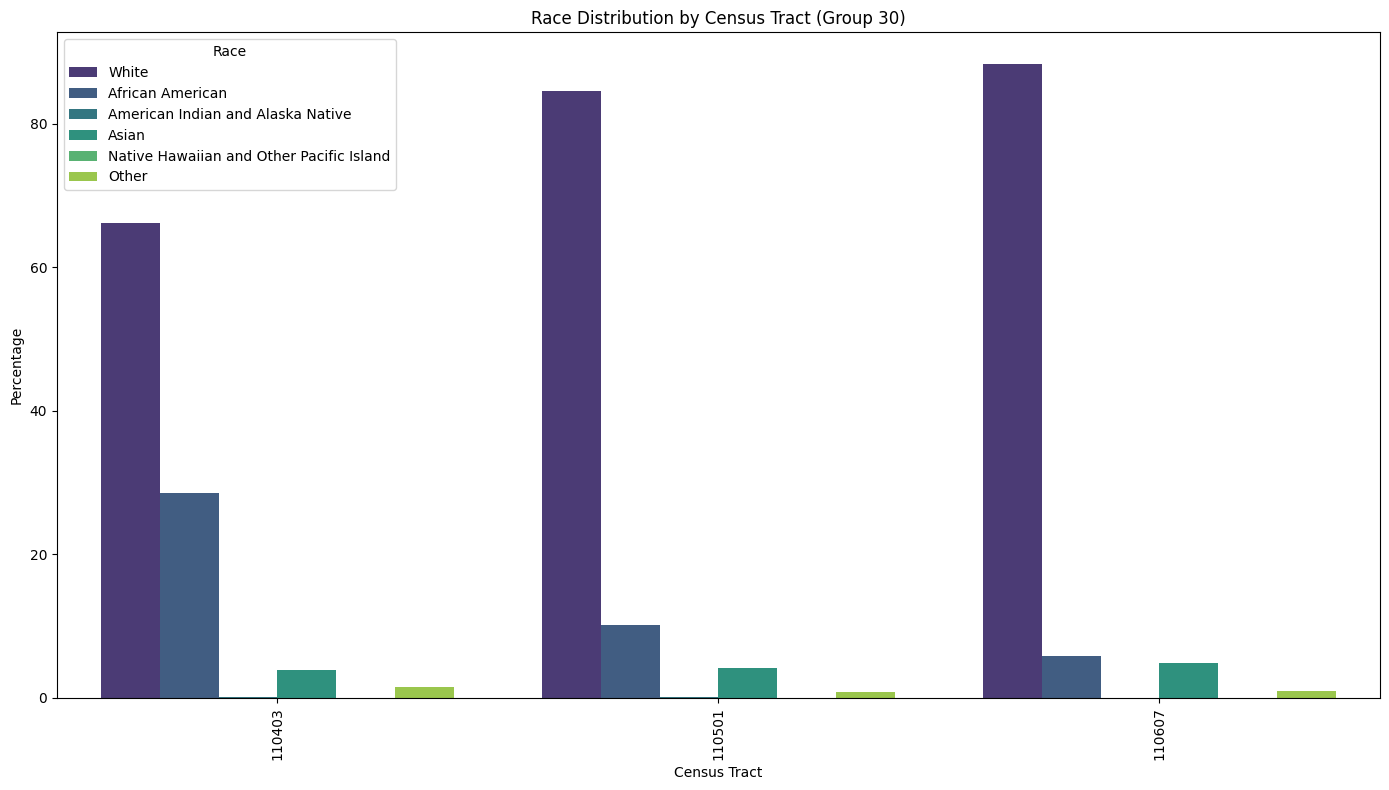

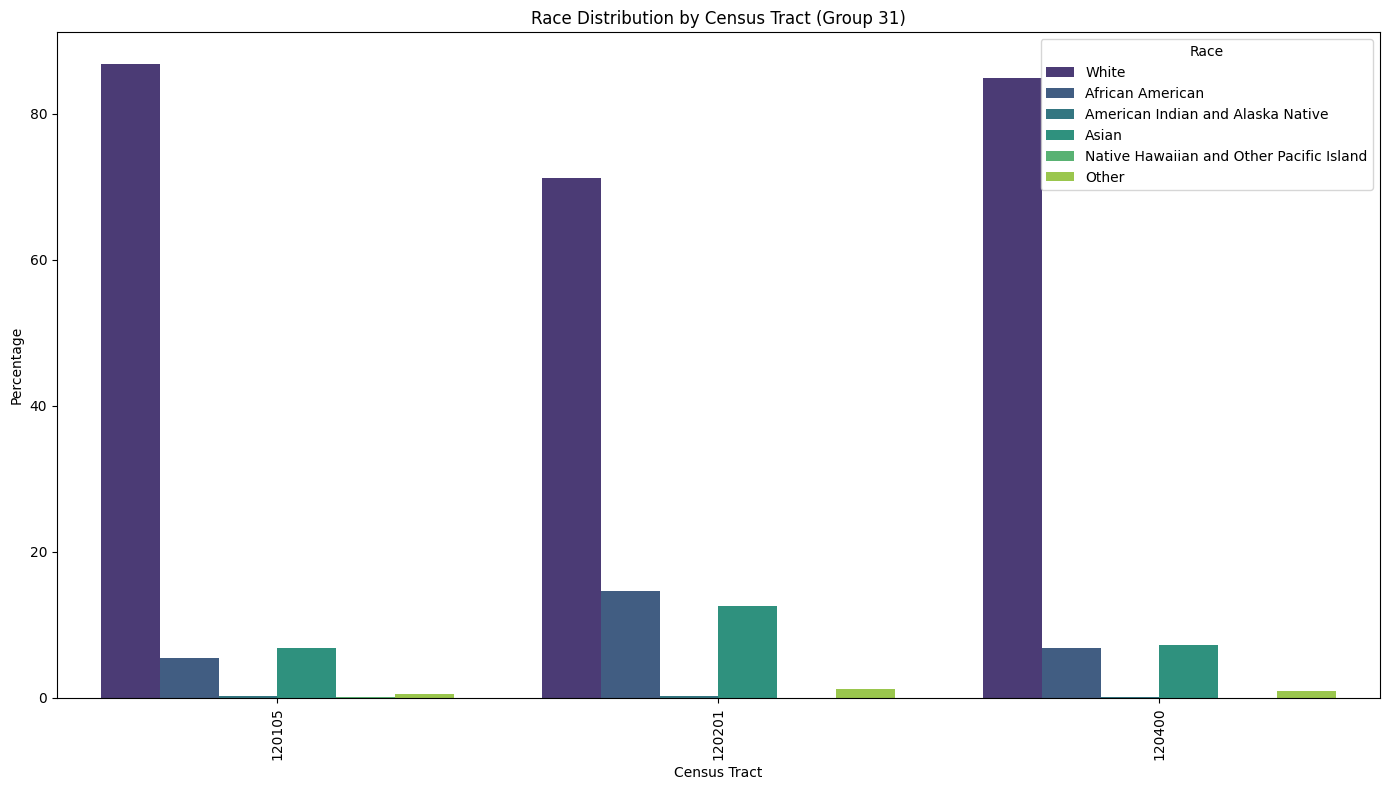

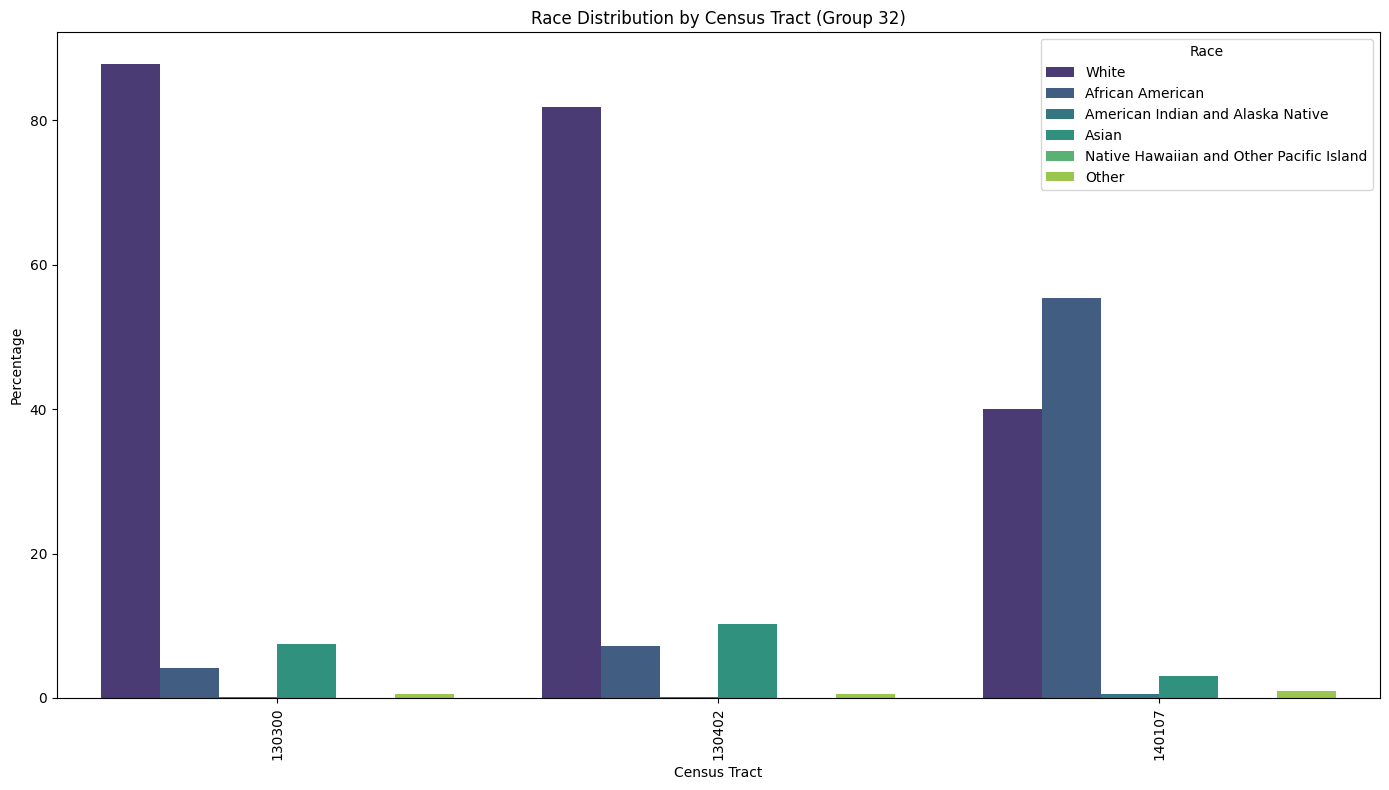

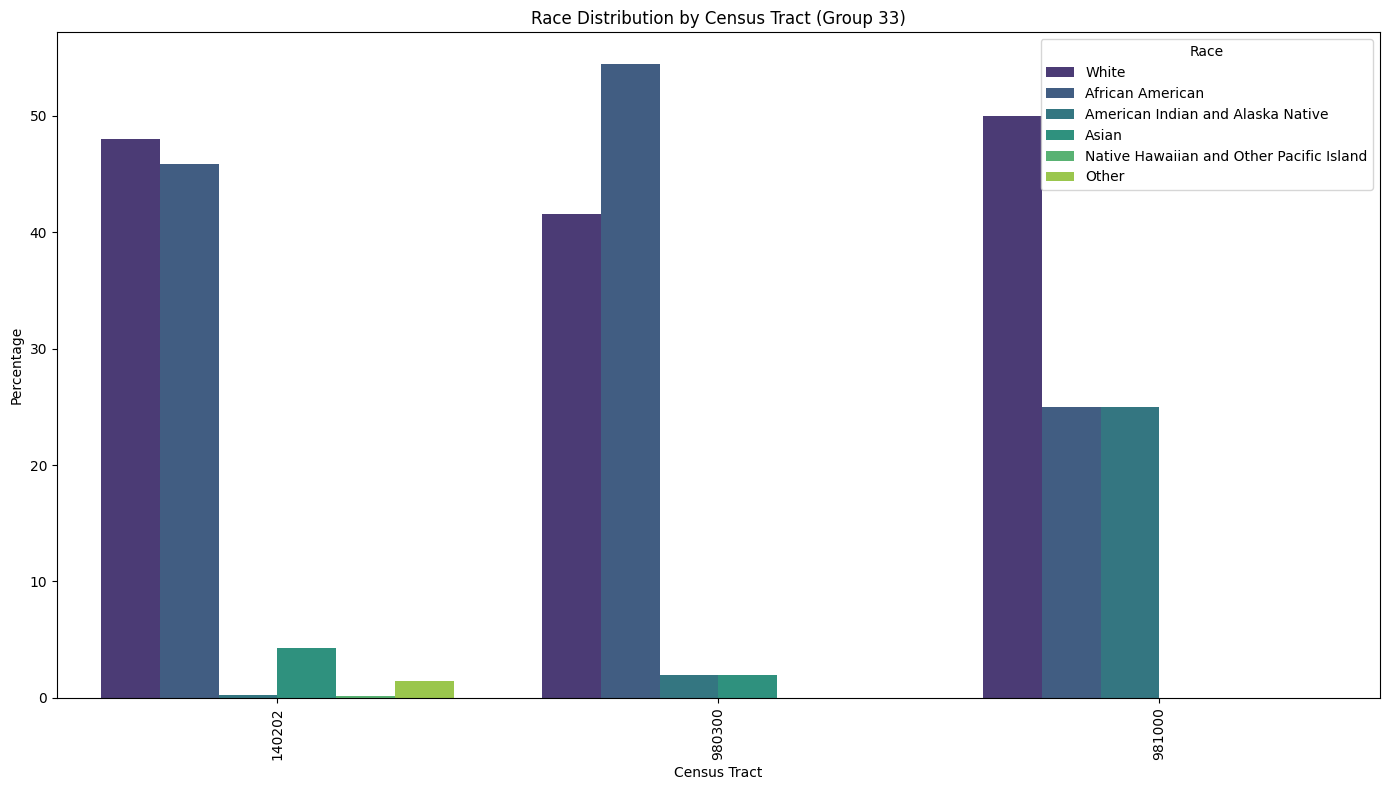

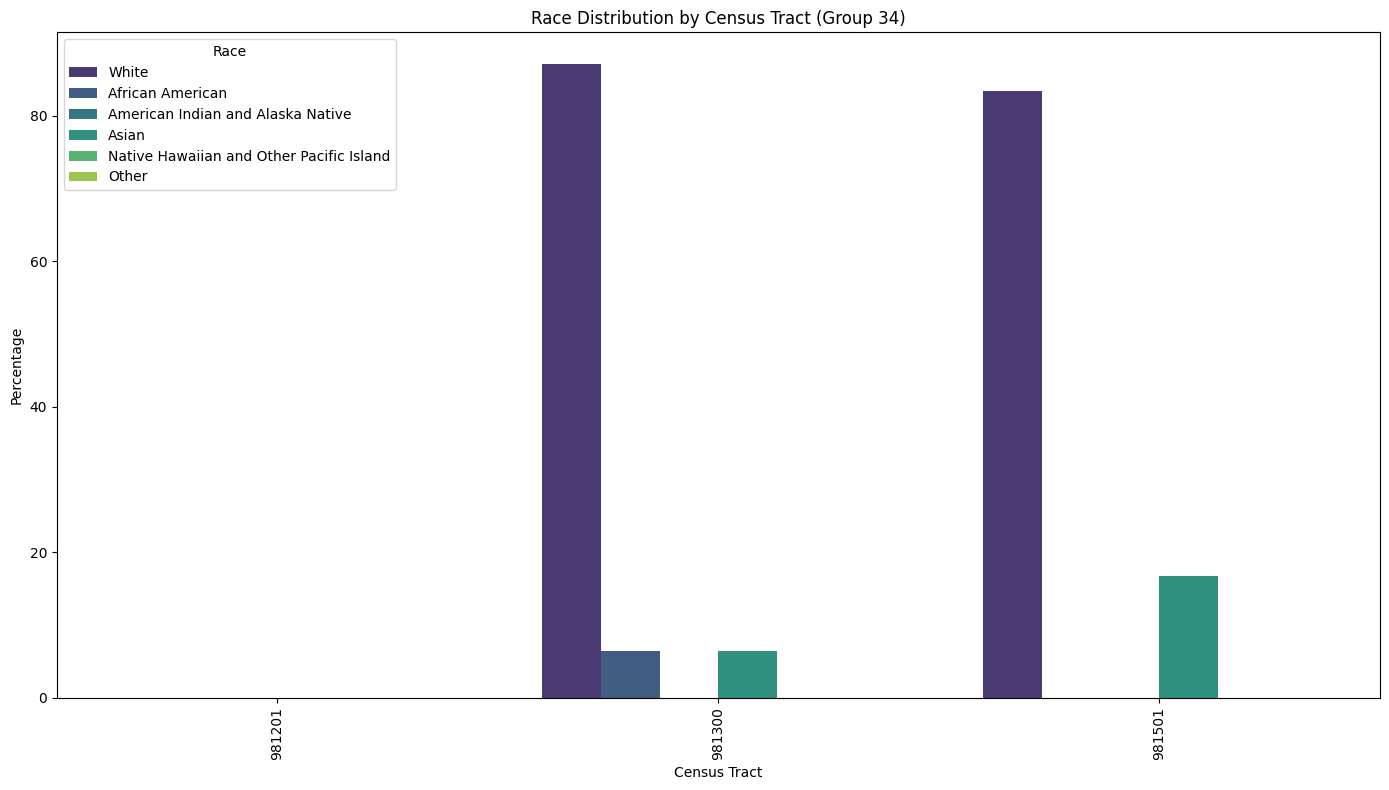

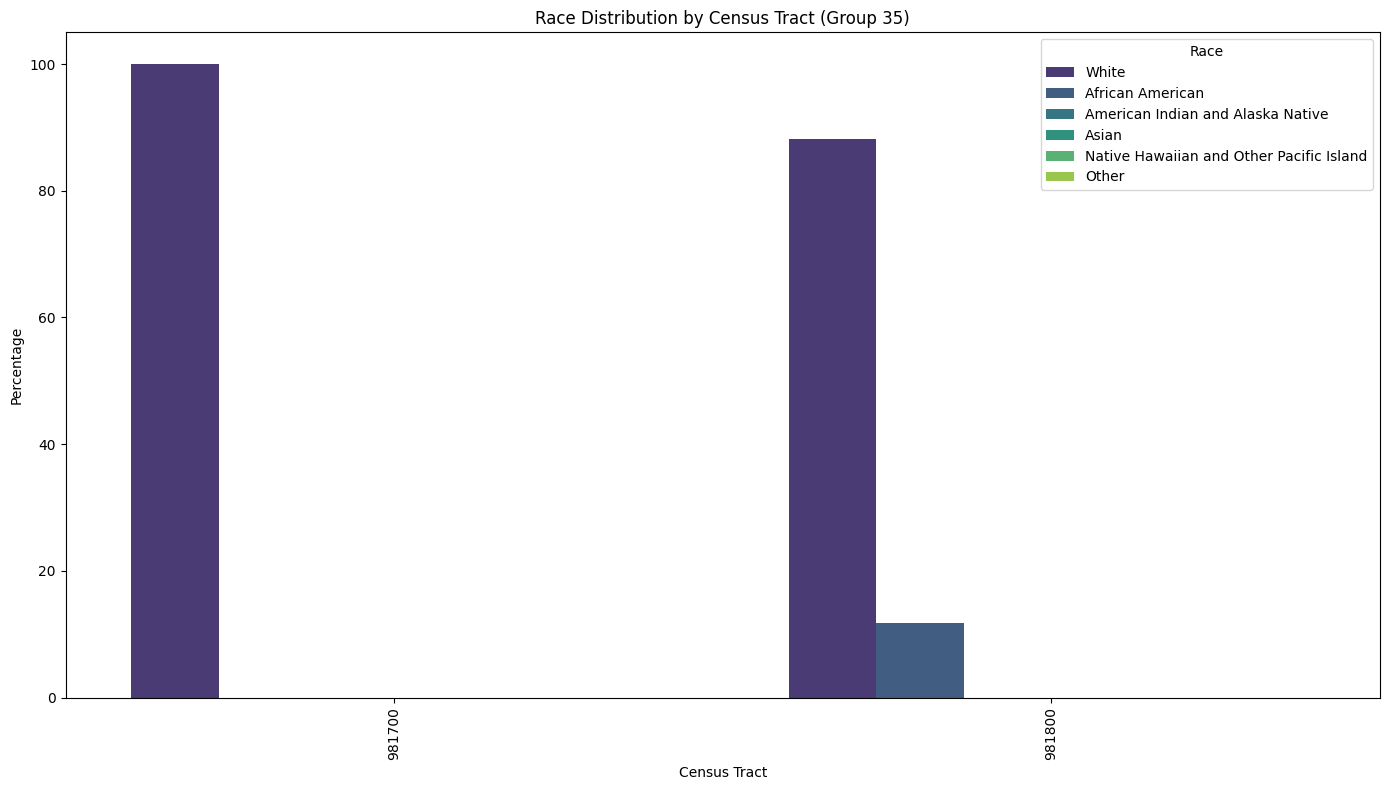

In [11]:
# Determine the number of tracts per graph
tracts_per_graph = 3

# Split the DataFrame into chunks
num_chunks = int(np.ceil(len(race_distribution_by_tract_percentage) / tracts_per_graph))
chunks = np.array_split(race_distribution_by_tract_percentage, num_chunks)

# Create individual bar charts for each chunk
for i, chunk in enumerate(chunks):
    plt.figure(figsize=(14, 8))
    chunk_melted = chunk.melt(id_vars='Census Tract', var_name='Race', value_name='Percentage')
    sns.barplot(data=chunk_melted, x='Census Tract', y='Percentage', hue='Race', palette='viridis')
    plt.title(f'Race Distribution by Census Tract (Group {i + 1})')
    plt.xlabel('Census Tract')
    plt.ylabel('Percentage')
    plt.xticks(rotation=90)
    plt.legend(title='Race')
    plt.tight_layout()
    plt.show()